In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm
from scipy.stats import binomtest, binom
from scipy.optimize import minimize
from scipy.optimize import minimize


# Importation des données

In [2]:
# import yfinance as yf
# import numpy as np
# import matplotlib.pyplot as plt
# import pandas as pd

# # Télécharger les données
# df = yf.download("^GDAXI", start="2000-01-01", end="2026-01-01")

# # Calculer les rendements logarithmiques
# df['returns'] = np.log(df['Close'] / df['Close'].shift(1))


In [3]:
df = pd.read_csv('../data/dax.csv')
df['Date']=pd.to_datetime(df['Date'],yearfirst=True)
df = df.set_index(df['Date'])
df.head()

,Date,Close,High,Low,Open,Volume,returns
Date,,,,,,,
2000-01-03,2000-01-03,6750.759766,7159.330078,6720.870117,6961.720215,43072500,NaN
2000-01-04,2000-01-04,6586.950195,6755.359863,6510.459961,6747.240234,46678400,-0.024565
2000-01-05,2000-01-05,6502.069824,6585.850098,6388.910156,6585.850098,52682800,-0.012970
2000-01-06,2000-01-06,6474.919922,6539.310059,6402.629883,6501.450195,41180600,-0.004184
2000-01-07,2000-01-07,6780.959961,6791.529785,6470.140137,6489.939941,56058900,0.046182


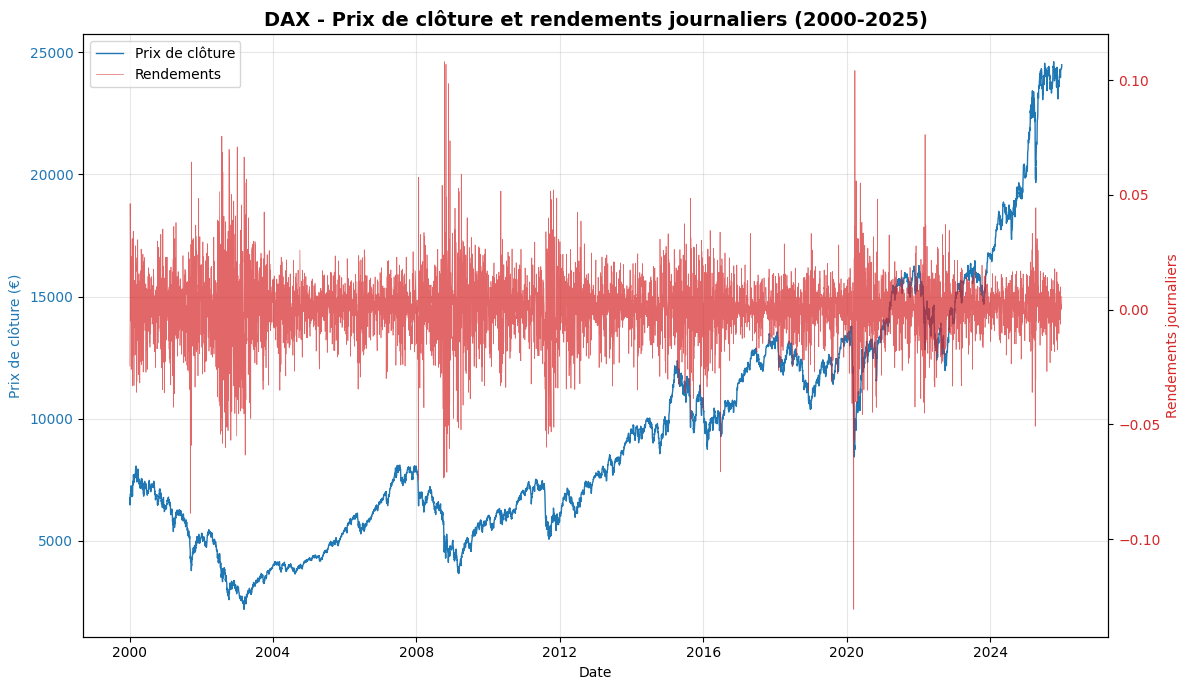

In [4]:
# Créer la figure avec deux axes Y
fig, ax1 = plt.subplots(figsize=(12, 7))

# Premier axe Y (gauche) - Prix de clôture
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Prix de clôture (€)', color=color)
ax1.plot(df['Date'], df['Close'], color=color, linewidth=1, label='Prix de clôture')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)

# Deuxième axe Y (droite) - Rendements
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Rendements journaliers', color=color)
ax2.plot(df['Date'], df['returns'], color=color, alpha=0.7, linewidth=0.5, label='Rendements')
ax2.tick_params(axis='y', labelcolor=color)

# Titre et légende
plt.title('DAX - Prix de clôture et rendements journaliers (2000-2025)', fontsize=14, fontweight='bold')

# Créer une légende combinée
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()

# Etude volatilité

Les périodes de forte volatilité sont détectées automatiquement en identifiant les instants où une mesure locale de dispersion dépasse un seuil extrême défini par un quantile élevé de sa distribution empirique. Cette approche permet de capturer les régimes de marché caractérisés par une accumulation d’événements extrêmes.

Les périodes de forte volatilité détectées correspondent à des phases de stress de marché, caractérisées par une augmentation marquée de l’amplitude des rendements. Le découpage retenu permet de calibrer les modèles de risque sur une période stable, puis d’évaluer leurs performances lors d’une phase de forte instabilité, ce qui correspond à un cadre réaliste de gestion du risque.

In [5]:
def plot_volatility_periods(returns, periods, title=None):
    """
    returns : pd.Series (index = dates)
    periods : liste de tuples (start_date, end_date)
    """

    plt.figure(figsize=(12, 5))
    plt.plot(returns.index, returns.values, label="Rendements", linewidth=1)

    # Zones de forte volatilité
    for i, (start, end) in enumerate(periods):
        plt.axvspan(start, end, alpha=0.3, color = 'red',
                    label="Forte volatilité" if i == 0 else None)

    plt.axhline(0, linestyle="--", linewidth=0.8)
    plt.xlabel("Date")
    plt.ylabel("Rendement")
    plt.title(title if title else "Périodes de forte volatilité")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [6]:
returns = df['returns']
returns.index = df['Date']

## Détection des périodes de forte volatilité sur des fenetres glissantes

La volatilité des rendements étant variable dans le temps, une mesure locale est estimée à l’aide d’une volatilité calculée sur une fenêtre glissante. À chaque date $t$, la volatilité roulante $\sigma_t$ correspond à l’écart-type des rendements observés sur les $h$ périodes précédentes.

Afin d’identifier les régimes de marché instables, un seuil de forte volatilité est défini comme un quantile élevé de la distribution empirique de $\sigma_t$. Une date est considérée comme appartenant à une phase de forte volatilité lorsque $\sigma_t$ dépasse ce seuil.

Les périodes de forte volatilité sont ensuite définies comme des intervalles de temps continus pour lesquels cette condition est vérifiée.


In [7]:
def detect_high_volatility_periods(
    returns,
    window=20,
    quantile=0.95
):
    """
    returns : pd.Series (index = dates)
    window  : taille de la fenêtre roulante
    quantile: seuil de forte volatilité
    """

    # 1️⃣ Volatilité roulante (RMS)
    rolling_vol = np.sqrt(
        returns.rolling(window).mean()**2 +
        returns.rolling(window).var()
    )

    # Version encore plus simple et classique :
    # rolling_vol = returns.rolling(window).std()

    # 2️⃣ Seuil extrême
    threshold = rolling_vol.quantile(quantile)

    # 3️⃣ Indicateur forte volatilité
    high_vol = rolling_vol > threshold

    # 4️⃣ Extraction des périodes continues
    periods = []
    in_period = False

    for date, is_high in high_vol.items():
        if is_high and not in_period:
            start = date
            in_period = True
        elif not is_high and in_period:
            end = date
            periods.append((start, end))
            in_period = False

    # Cas où la série finit en période de forte vol
    if in_period:
        periods.append((start, high_vol.index[-1]))

    return periods


In [8]:
periods1 = detect_high_volatility_periods(returns,window=80)

for i, (start, end) in enumerate(periods1, 1):
    print(f"Période de forte volatilité n°{i} : du {start.date()} au {end.date()}")


Période de forte volatilité n°1 : du 2002-08-08 au 2003-02-13
Période de forte volatilité n°2 : du 2003-02-14 au 2003-02-17
Période de forte volatilité n°3 : du 2003-03-21 au 2003-04-28
Période de forte volatilité n°4 : du 2008-10-28 au 2009-03-18
Période de forte volatilité n°5 : du 2011-11-11 au 2011-11-25
Période de forte volatilité n°6 : du 2011-11-28 au 2011-11-29
Période de forte volatilité n°7 : du 2011-11-30 au 2011-12-01
Période de forte volatilité n°8 : du 2020-04-06 au 2020-07-08


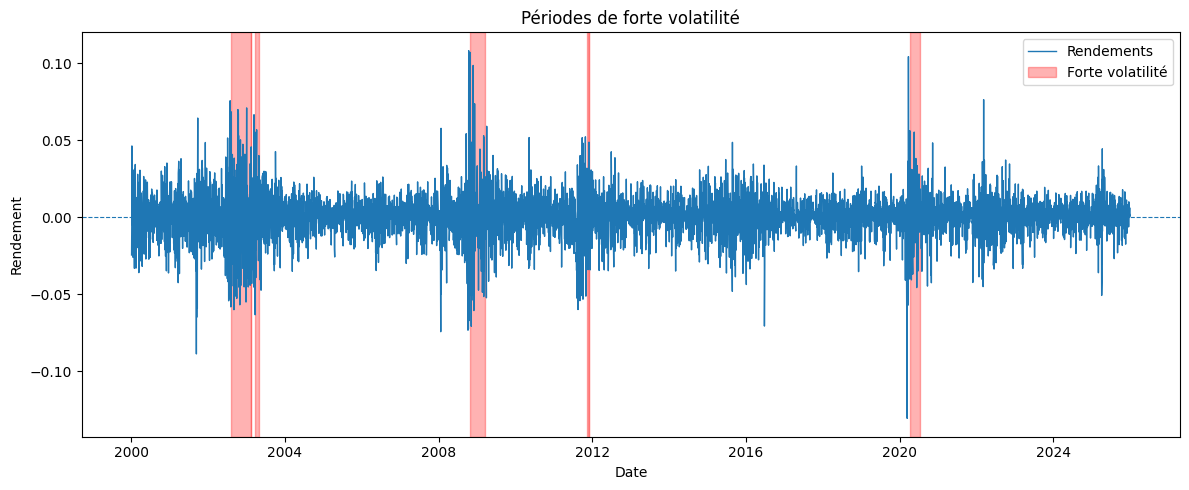

In [9]:
plot_volatility_periods(returns, periods1)

## Détection des périodes de forte volatilité – Approche POT

La forte volatilité se manifeste par une fréquence élevée de rendements de grande amplitude. On considère donc la série des valeurs absolues des rendements $X_t = |r_t|$ et on applique une approche de type Peaks Over Threshold (POT).

Un seuil élevé $u$ est défini comme un quantile de la distribution empirique de $X_t$. Les observations telles que $X_t > u$ sont interprétées comme des événements extrêmes.

Les périodes de forte volatilité sont identifiées en comptabilisant, sur une fenêtre glissante, le nombre d’excès au-dessus du seuil. Un intervalle de temps est considéré comme un régime de forte volatilité lorsque cette fréquence dépasse un niveau donné.


In [10]:
def detect_extreme_volatility_periods(
    returns,
    window=20,
    quantile=0.95,
    min_exceedances=4
):
    """
    returns : pd.Series (index = dates)
    window  : fenêtre glissante
    quantile: seuil POT
    min_exceedances : nombre minimal d'excès dans la fenêtre
    """

    # 1️⃣ Valeurs absolues
    abs_returns = returns.abs()

    # 2️⃣ Seuil POT
    threshold = abs_returns.quantile(quantile)

    # 3️⃣ Indicateur d'excès
    exceedances = abs_returns > threshold

    # 4️⃣ Comptage glissant des excès
    rolling_exceedances = exceedances.rolling(window).sum()

    # 5️⃣ Régime de forte volatilité
    high_vol = rolling_exceedances >= min_exceedances

    # 6️⃣ Extraction des périodes continues
    periods = []
    in_period = False

    for date, is_high in high_vol.items():
        if is_high and not in_period:
            start = date
            in_period = True
        elif not is_high and in_period:
            end = date
            periods.append((start, end))
            in_period = False

    if in_period:
        periods.append((start, high_vol.index[-1]))

    return periods


In [11]:
periods2 = detect_extreme_volatility_periods(returns,window=80)

for i, (start, end) in enumerate(periods2, 1):
    print(f"Période de forte volatilité n°{i} : du {start.date()} au {end.date()}")


Période de forte volatilité n°1 : du 2000-04-25 au 2000-07-06
Période de forte volatilité n°2 : du 2000-12-05 au 2001-07-20
Période de forte volatilité n°3 : du 2001-09-11 au 2002-04-05
Période de forte volatilité n°4 : du 2002-06-17 au 2003-08-28
Période de forte volatilité n°5 : du 2003-09-24 au 2003-10-22
Période de forte volatilité n°6 : du 2003-11-17 au 2004-01-19
Période de forte volatilité n°7 : du 2008-02-05 au 2008-06-06
Période de forte volatilité n°8 : du 2008-10-06 au 2009-10-12
Période de forte volatilité n°9 : du 2010-05-27 au 2010-08-30
Période de forte volatilité n°10 : du 2011-08-08 au 2012-04-03
Période de forte volatilité n°11 : du 2012-04-04 au 2012-04-13
Période de forte volatilité n°12 : du 2012-04-23 au 2012-04-25
Période de forte volatilité n°13 : du 2012-06-01 au 2012-10-22
Période de forte volatilité n°14 : du 2015-01-08 au 2015-02-11
Période de forte volatilité n°15 : du 2015-07-10 au 2016-01-18
Période de forte volatilité n°16 : du 2016-02-08 au 2016-04-27
P

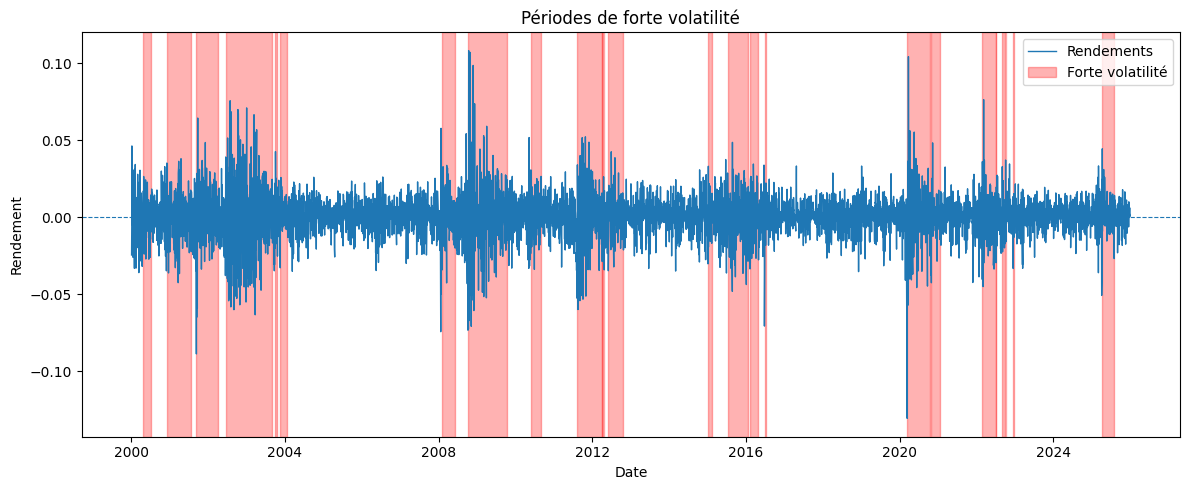

In [12]:
plot_volatility_periods(returns, periods2)

## Détection des périodes de forte volatilité – Approche GARCH

La volatilité des rendements est modélisée à l’aide d’un modèle GARCH(1,1), permettant de capturer la dépendance temporelle et la persistance de la volatilité.

À partir de la volatilité conditionnelle estimée, un seuil de forte volatilité est défini comme un quantile élevé de sa distribution empirique. Les périodes de forte volatilité correspondent alors aux intervalles de temps durant lesquels la volatilité conditionnelle dépasse ce seuil.


In [13]:
from arch import arch_model

def detect_garch_volatility_periods(
    returns,
    quantile=0.95
):
    """
    returns : pd.Series (index = dates)
    """
    returns = returns.copy()
    returns = returns.dropna()

    # 1️⃣ Estimation GARCH(1,1)
    model = arch_model(returns * 100, vol="Garch", p=1, q=1, mean="Zero")
    res = model.fit(disp="off")

    # 2️⃣ Volatilité conditionnelle
    cond_vol = res.conditional_volatility
    cond_vol.index = returns.index

    # 3️⃣ Seuil extrême
    threshold = cond_vol.quantile(quantile)

    # 4️⃣ Régimes de forte volatilité
    high_vol = cond_vol > threshold

    # 5️⃣ Extraction des périodes continues
    periods = []
    in_period = False

    for date, is_high in high_vol.items():
        if is_high and not in_period:
            start = date
            in_period = True
        elif not is_high and in_period:
            end = date
            periods.append((start, end))
            in_period = False

    if in_period:
        periods.append((start, high_vol.index[-1]))

    return periods, cond_vol


In [14]:
periods3, cond_vol = detect_garch_volatility_periods(returns,quantile=0.95)

for i, (start, end) in enumerate(periods3, 1):
    print(f"Période de forte volatilité n°{i} : du {start.date()} au {end.date()}")


Période de forte volatilité n°1 : du 2001-09-12 au 2001-10-10
Période de forte volatilité n°2 : du 2001-10-11 au 2001-10-12
Période de forte volatilité n°3 : du 2002-07-08 au 2002-07-10
Période de forte volatilité n°4 : du 2002-07-11 au 2002-07-15
Période de forte volatilité n°5 : du 2002-07-16 au 2002-11-20
Période de forte volatilité n°6 : du 2002-11-28 au 2002-11-29
Période de forte volatilité n°7 : du 2002-12-11 au 2002-12-12
Période de forte volatilité n°8 : du 2002-12-17 au 2002-12-18
Période de forte volatilité n°9 : du 2002-12-19 au 2002-12-27
Période de forte volatilité n°10 : du 2002-12-30 au 2003-01-15
Période de forte volatilité n°11 : du 2003-01-20 au 2003-01-21
Période de forte volatilité n°12 : du 2003-02-20 au 2003-02-21
Période de forte volatilité n°13 : du 2003-02-26 au 2003-02-27
Période de forte volatilité n°14 : du 2003-03-14 au 2003-04-17
Période de forte volatilité n°15 : du 2008-01-22 au 2008-01-23
Période de forte volatilité n°16 : du 2008-01-24 au 2008-02-01
P

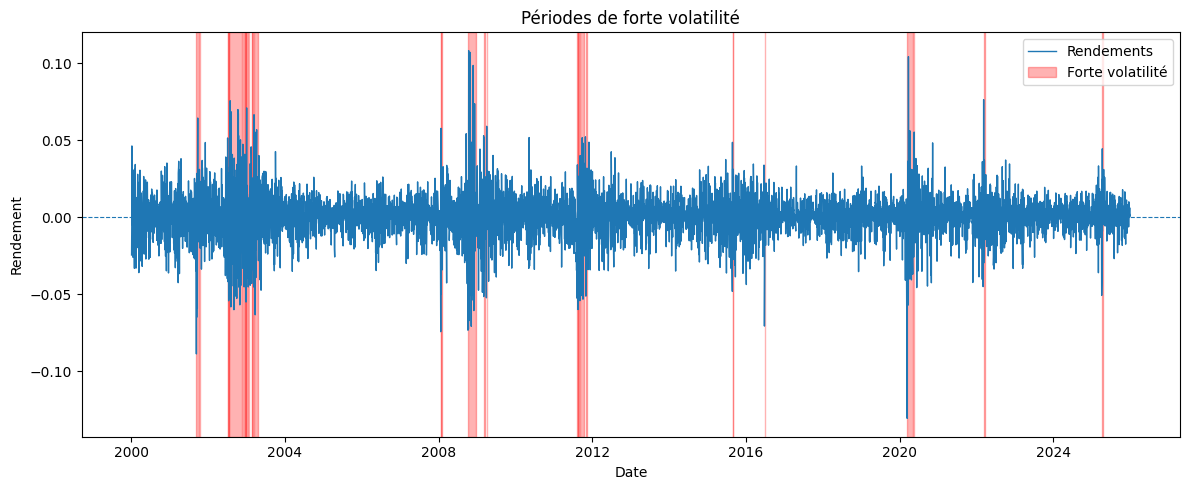

In [15]:
plot_volatility_periods(returns, periods3)

# train test split

In [16]:
bornes = ['2016-07-06','2020-03-06','2020-10-14']

train = df[(df['Date'] >= bornes[0]) & 
                     (df['Date'] < bornes[1])]
test = df[(df['Date'] >= bornes[1]) & 
                    (df['Date'] <= bornes[2])]

print(f"Train shape: {train.shape[0]}, Période: {train.index[0]} à {train.index[-1]}")
print(f"Test shape: {test.shape[0]}, Période: {test.index[0]} à {test.index[-1]}")

Train shape: 926, Période: 2016-07-06 00:00:00 à 2020-03-05 00:00:00
Test shape: 155, Période: 2020-03-06 00:00:00 à 2020-10-14 00:00:00


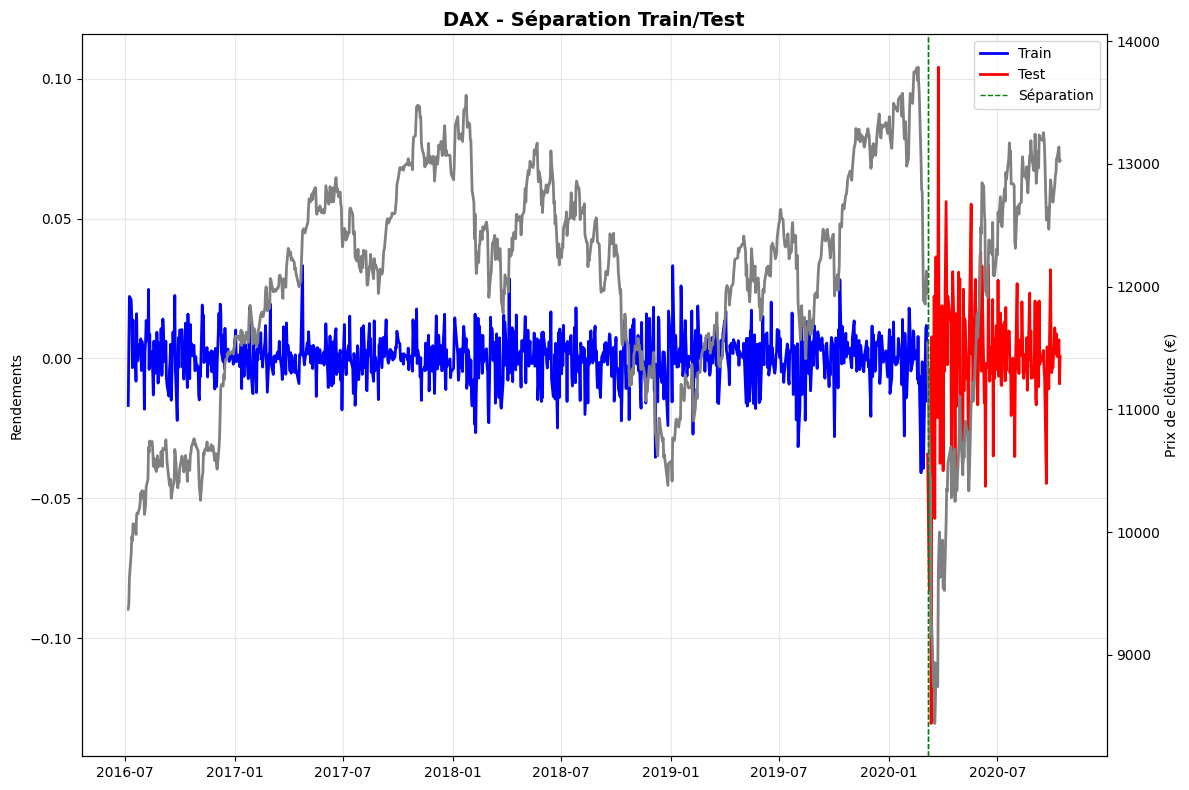

In [17]:
# Créer un graphique montrant les périodes train/test
fig, ax2 = plt.subplots(figsize=(12, 8))

# Graphique complet



ax2.plot(train.index, train['returns'], color='blue', linewidth=2, label='Train')
ax2.plot(test.index, test['returns'], color='red', linewidth=2, label='Test')
ax2.axvline(x=pd.Timestamp(bornes[1]), color='green', linestyle='--', 
            linewidth=1, label='Séparation')
ax2.set_ylabel('Rendements')
ax2.legend()
ax2.grid(True, alpha=0.3)

ax1 = ax2.twinx()
ax1.plot(train.index, train['Close'], color='gray', linewidth=2)
ax1.plot(test.index, test['Close'], color='gray', linewidth=2)
ax1.axvline(x=pd.Timestamp(bornes[1]), color='green', linestyle='--', 
            linewidth=1, label='Séparation')
ax1.set_title('DAX - Séparation Train/Test', fontsize=14, fontweight='bold')
ax1.set_ylabel('Prix de clôture (€)')


plt.tight_layout()
plt.show()

In [18]:
# Fonction pour des statistiques complètes
def detailed_stats(dataframe, name):
    stats_dict = {}
    
    for column in ['Close', 'returns']:
        if column in dataframe.columns:
            col_data = dataframe[column].dropna()
            stats_dict[f'{column}_mean'] = col_data.mean()
            stats_dict[f'{column}_std'] = col_data.std()
            stats_dict[f'{column}_min'] = col_data.min()
            stats_dict[f'{column}_max'] = col_data.max()
            stats_dict[f'{column}_median'] = col_data.median()
            stats_dict[f'{column}_skew'] = col_data.skew()
            stats_dict[f'{column}_kurtosis'] = col_data.kurtosis()
            stats_dict[f'{column}_q25'] = col_data.quantile(0.25)
            stats_dict[f'{column}_q75'] = col_data.quantile(0.75)
            stats_dict[f'{column}_count'] = len(col_data)
    
    return pd.DataFrame(stats_dict, index=[name])

# Calculer les statistiques
train_stats = detailed_stats(train[['returns']], 'Train')
test_stats = detailed_stats(test[['returns']], 'Test')

# Combiner et afficher
comparison_stats = pd.concat([train_stats, test_stats])
print("\nCOMPARAISON DES STATISTIQUES TRAIN/TEST :")
print(comparison_stats.round(4))


COMPARAISON DES STATISTIQUES TRAIN/TEST :
       returns_mean  returns_std  returns_min  returns_max  returns_median  \
Train        0.0002       0.0089      -0.0409       0.0332          0.0007   
Test         0.0006       0.0243      -0.1305       0.1041          0.0007   

       returns_skew  returns_kurtosis  returns_q25  returns_q75  returns_count  
Train       -0.4131            1.8855      -0.0042       0.0053            926  
Test        -0.8892            7.4385      -0.0071       0.0124            155  


C:\Users\UltraBook 3.1\AppData\Local\Temp\ipykernel_24048\2805866505.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax3.boxplot(data_to_plot, labels=['Train', 'Test'])


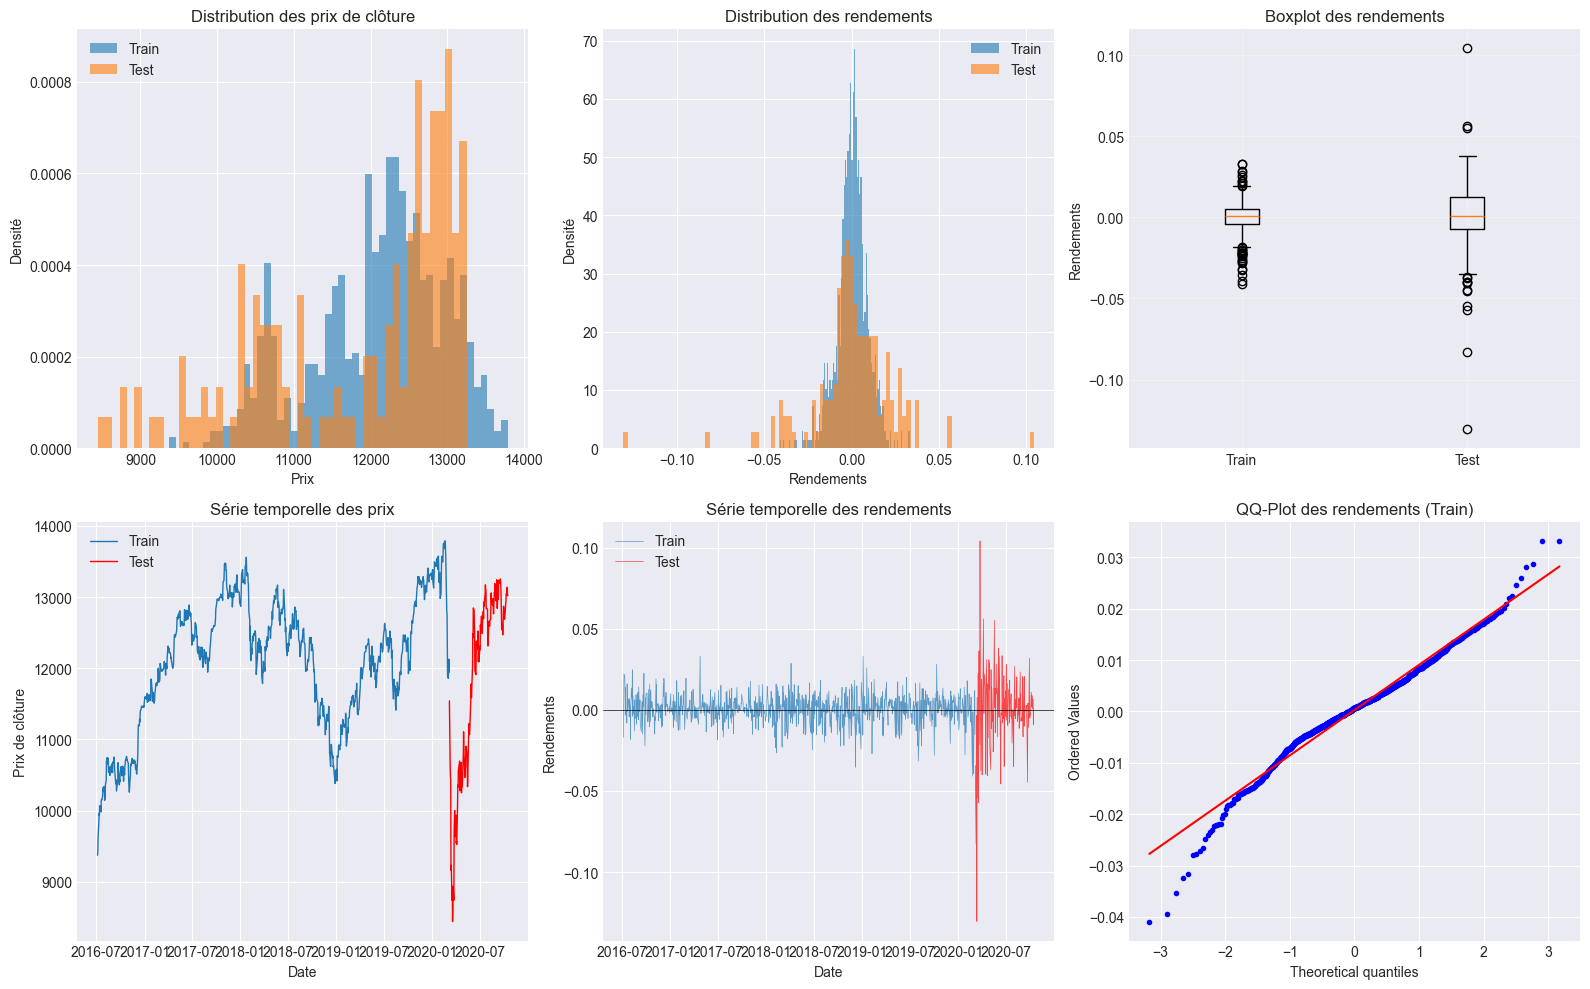

In [19]:
# Configuration du style
plt.style.use('seaborn-v0_8-darkgrid')
fig = plt.figure(figsize=(16, 10))

# 1. Distribution des prix de clôture
ax1 = plt.subplot(2, 3, 1)
ax1.hist(train['Close'].dropna(), bins=50, alpha=0.6, label='Train', density=True)
ax1.hist(test['Close'].dropna(), bins=50, alpha=0.6, label='Test', density=True)
ax1.set_title('Distribution des prix de clôture')
ax1.set_xlabel('Prix')
ax1.set_ylabel('Densité')
ax1.legend()

# 2. Distribution des rendements
ax2 = plt.subplot(2, 3, 2)
ax2.hist(train['returns'].dropna(), bins=100, alpha=0.6, label='Train', density=True)
ax2.hist(test['returns'].dropna(), bins=100, alpha=0.6, label='Test', density=True)
ax2.set_title('Distribution des rendements')
ax2.set_xlabel('Rendements')
ax2.set_ylabel('Densité')
ax2.legend()

# 3. Boxplot des rendements
ax3 = plt.subplot(2, 3, 3)
data_to_plot = [train['returns'].dropna(), test['returns'].dropna()]
ax3.boxplot(data_to_plot, labels=['Train', 'Test'])
ax3.set_title('Boxplot des rendements')
ax3.set_ylabel('Rendements')
ax3.grid(True, alpha=0.3)

# 4. Série temporelle des prix
ax4 = plt.subplot(2, 3, 4)
ax4.plot(train.index, train['Close'], label='Train', linewidth=1)
ax4.plot(test.index, test['Close'], label='Test', linewidth=1, color='red')
ax4.set_title('Série temporelle des prix')
ax4.set_xlabel('Date')
ax4.set_ylabel('Prix de clôture')
ax4.legend()

# 5. Série temporelle des rendements
ax5 = plt.subplot(2, 3, 5)
ax5.plot(train.index, train['returns'], label='Train', linewidth=0.5, alpha=0.7)
ax5.plot(test.index, test['returns'], label='Test', linewidth=0.5, alpha=0.7, color='red')
ax5.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax5.set_title('Série temporelle des rendements')
ax5.set_xlabel('Date')
ax5.set_ylabel('Rendements')
ax5.legend()

# 6. QQ-Plot pour la normalité des rendements
ax6 = plt.subplot(2, 3, 6)
stats.probplot(train['returns'].dropna(), dist="norm", plot=ax6)
ax6.set_title('QQ-Plot des rendements (Train)')
ax6.get_lines()[0].set_markersize(3)

plt.tight_layout()
plt.show()

In [20]:
# Calcul des métriques de risque
def calculate_risk_metrics(returns_series, name, risk_free_rate=0.02/252):
    """Calcule les métriques de risque"""
    returns = returns_series.dropna()
    
    metrics = {
        'Période': name,
        'Nb_observations': len(returns),
        'Rendement_moyen_journalier': returns.mean(),
        'Rendement_annualisé': returns.mean() * 252,
        'Volatilité_journalière': returns.std(),
        'Volatilité_annualisée': returns.std() * np.sqrt(252),
        'Ratio_de_Sharpe': (returns.mean() - risk_free_rate) / returns.std() * np.sqrt(252),
        'Skewness': returns.skew(),
        'Kurtosis': returns.kurtosis(),
        'VaR_95%': returns.quantile(0.05),
        'ES_95%': returns[returns <= returns.quantile(0.05)].mean(),
        'Maximum_Drawdown': (returns.cumsum().expanding().max() - returns.cumsum()).max(),
        'Ratio_Sortino': returns.mean() / returns[returns < 0].std()
    }
    
    return metrics

# Calculer pour train et test
train_metrics = calculate_risk_metrics(train['returns'], 'Train')
test_metrics = calculate_risk_metrics(test['returns'], 'Test')

# Créer un DataFrame comparatif
risk_comparison = pd.DataFrame([train_metrics, test_metrics]).set_index('Période')
print("\n" + "=" * 60)
print("COMPARAISON DES MÉTRIQUES DE RISQUE")
print("=" * 60)
print(risk_comparison.round(4))


COMPARAISON DES MÉTRIQUES DE RISQUE
         Nb_observations  Rendement_moyen_journalier  Rendement_annualisé  \
Période                                                                     
Train                926                      0.0002               0.0614   
Test                 155                      0.0006               0.1411   

         Volatilité_journalière  Volatilité_annualisée  Ratio_de_Sharpe  \
Période                                                                   
Train                    0.0089                 0.1413           0.2928   
Test                     0.0243                 0.3856           0.3142   

         Skewness  Kurtosis  VaR_95%  ES_95%  Maximum_Drawdown  Ratio_Sortino  
Période                                                                        
Train     -0.4131    1.8855  -0.0153 -0.0210            0.2671         0.0369  
Test      -0.8892    7.4385  -0.0399 -0.0621            0.3128         0.0267  


In [21]:
from scipy.stats import ttest_ind, ks_2samp, levene

print("\n" + "=" * 60)
print("TESTS STATISTIQUES COMPARATIFS")
print("=" * 60)

# T-test pour différence des moyennes
t_stat, p_value = ttest_ind(train['returns'].dropna(), test['returns'].dropna(), 
                            equal_var=False)
print(f"Test t pour égalité des moyennes:")
print(f"  t-statistique = {t_stat:.4f}, p-value = {p_value:.4f}")
print(f"  Conclusion: {'Différence significative' if p_value < 0.05 else 'Pas de différence significative'}")

# Test de Kolmogorov-Smirnov
ks_stat, ks_p = ks_2samp(train['returns'].dropna(), test['returns'].dropna())
print(f"\nTest de Kolmogorov-Smirnov:")
print(f"  KS-statistique = {ks_stat:.4f}, p-value = {ks_p:.4f}")
print(f"  Conclusion: {'Distributions différentes' if ks_p < 0.05 else 'Distributions similaires'}")

# Test de Levene pour égalité des variances
levene_stat, levene_p = levene(train['returns'].dropna(), test['returns'].dropna())
print(f"\nTest de Levene pour égalité des variances:")
print(f"  Statistique = {levene_stat:.4f}, p-value = {levene_p:.4f}")
print(f"  Conclusion: {'Variances différentes' if levene_p < 0.05 else 'Variances égales'}")


TESTS STATISTIQUES COMPARATIFS
Test t pour égalité des moyennes:
  t-statistique = -0.1604, p-value = 0.8727
  Conclusion: Pas de différence significative

Test de Kolmogorov-Smirnov:
  KS-statistique = 0.1973, p-value = 0.0001
  Conclusion: Distributions différentes

Test de Levene pour égalité des variances:
  Statistique = 141.0488, p-value = 0.0000
  Conclusion: Variances différentes


# 1.	VaR non paramétrique


## 1.1 VaR historique
### a.	Ecrire une fonction calculant la VaR historique d’un ensemble de log-rendements VaR_Hist(x, alpha


In [22]:
alpha = 0.99

In [23]:
def VaR_Hist(x, alpha=0.95):
    """
    Calcule la Value at Risk (VaR) historique d'une série de rendements.
    
    Paramètres:
    -----------
    x : array-like ou Series
        Série des rendements logaritmiques
    alpha : float
        Niveau de confiance (ex: 0.95 pour 95%, 0.99 pour 99%)
    
    Retourne:
    ---------
    float : VaR historique au niveau alpha
    """
    # S'assurer que x est un array numpy
    x = np.array(x)
    
    # Retirer les valeurs NaN
    x_clean = x[~np.isnan(x)]
    
    return np.percentile(x_clean, (1 - alpha) * 100)

### b.	Calculer la VaR historique sur base d’apprentissage pour alpha = 99%.

In [24]:
var_hist = VaR_Hist(train['returns'],alpha=alpha)
print('VaR historique à 99 % :', round(var_hist,5))

VaR historique à 99 % : -0.02468


### c.	Ecrire une fonction calculant la VaR historique bootstrap 
d’un ensemble de log-rendements et donnant un IC de niveau alpha_IC de cette VaR
 VaR_Hist_Bootstrap(x, alpha, B, alpha_IC)


In [25]:
def VaR_Hist_Bootstrap(x, alpha=0.95, B=1000, alpha_IC=0.95,seed = 42):
    """
    Calcule la VaR historique par bootstrap avec intervalle de confiance.
    
    Paramètres:
    -----------
    x : array-like
        Série des rendements logaritmiques
    alpha : float
        Niveau de confiance de la VaR (ex: 0.95 pour 95%)
    B : int
        Nombre de réplications bootstrap
    alpha_IC : float
        Niveau de confiance de l'intervalle (ex: 0.95 pour 95%)
    seed : int
        graine aléatoire pour la reproductivité
    """
    # Conversion et nettoyage
    x = np.asarray(x).flatten()
    x_clean = x[~np.isnan(x)]
    n = len(x_clean)
    
    # Fixer la seed
    np.random.seed(seed)
    
    
    # Créer une matrice de taille (B, n) avec des tirages aléatoires d'indices
    indices = np.random.randint(0, n, size=(B, n))

    # Créer une matrice (B, n) d'échantillons bootstrap
    bootstrap_samples = x_clean[indices]
    
    percentiles = (1 - alpha) * 100
    bootstrap_vars = np.percentile(bootstrap_samples, percentiles, axis=1)
    
    # Statistiques
    var_bootstrap = np.mean(bootstrap_vars)
    std_error = np.std(bootstrap_vars)
    
    # Intervalle de confiance
    lower_percentile = (1 - alpha_IC) / 2 * 100
    upper_percentile = (1 - (1 - alpha_IC) / 2) * 100
    
    ic_inf = np.percentile(bootstrap_vars, lower_percentile)
    ic_sup = np.percentile(bootstrap_vars, upper_percentile)
    
    return {
        'VaR_bootstrap': var_bootstrap,
        'IC_inf': ic_inf,
        'IC_sup': ic_sup,
        'std_error': std_error,
    }

### d.	Calculer la VaR historique bootstrap et l’IC associé à 90% sur base d’apprentissage pour alpha = 99%.

In [26]:
dict_boost = VaR_Hist_Bootstrap(train['returns'],alpha=alpha,alpha_IC=0.90)
print(f"\nEstimation bootstrap:")
print(f"  VaR bootstrap:      {dict_boost['VaR_bootstrap']:.6f}")
print(f"  Erreur standard:    {dict_boost['std_error']:.6f}")
print(f"  Borne inférieure:  {dict_boost['IC_inf']:.6f}")
print(f"  Borne supérieure:  {dict_boost['IC_sup']:.6f}")


Estimation bootstrap:
  VaR bootstrap:      -0.025091
  Erreur standard:    0.002317
  Borne inférieure:  -0.027996
  Borne supérieure:  -0.022156


### e.	Calculer le nombre d’exceptions sur base de test associées à la VaR historique calculée en 1.b.

In [27]:
def count_exceptions(returns, var_value, alpha=0.95,alternative='greater'):
    """
    Compte les exceptions (violations) dans une série de rendements.
    
    Paramètres:
    -----------
    returns : array-like
        Série des rendements
    var_value : float
        Valeur de la VaR (négative pour les pertes)
    alpha : float
        Niveau de confiance de la VaR
    
    Retourne:
    ---------
    dict : Statistiques des exceptions
    """
    returns_array = np.asarray(returns).flatten()
    returns_clean = returns_array[~np.isnan(returns_array)]
    
    # Les exceptions sont les rendements inférieurs à la VaR
    # (VaR est généralement négative, donc plus petite = pire)
    exceptions = returns_clean < var_value
    n_exceptions = np.sum(exceptions)
    n_obs = len(returns_clean)
    exception_rate = n_exceptions / n_obs
    
    # Statistiques attendues
    expected_exceptions = (1 - alpha) * n_obs
    bin = binomtest(
        k=n_exceptions,
        n= n_obs,
        p= 1-alpha,
        alternative=alternative
    )
    
    return {
        'VaR_value': var_value,
        'alpha': alpha,
        'n_observations': n_obs,
        'n_exceptions': int(n_exceptions),
        'exception_rate': exception_rate,
        'expected_exceptions': expected_exceptions,
        'binom_test': bin
        
    }

In [28]:
def plot_exceptions(returns_test,alpha, var,name = '',alternative='greater'):
    """
    Visualise les rendements, la VaR EWMA et les exceptions
    pour une valeur donnée de lambda
    """
    stats = count_exceptions(returns_test, var, alpha,alternative=alternative)
    # Identification des exceptions
    exceptions = returns_test[returns_test < var]
    
    plt.figure(figsize=(14, 6))
    
    # Rendements
    plt.plot(returns_test.index, returns_test.values,
             label='Log-rendements', color='steelblue', alpha=0.7)
    
    # VaR
    plt.axhline(var, color='red', linestyle='--',
                linewidth=2, label=f'VaR {name}')
    
    # Exceptions
    plt.scatter(exceptions.index, exceptions.values,
                color='red', s=40, zorder=3, label='Exceptions')
    
    # Texte statistiques
    textstr = (
        f"VaR 1j (99%) = {var:.2%}\n"
        f"Exceptions observées = {stats['n_exceptions']}\n"
        f"Exceptions attendues = {stats['expected_exceptions']:.2f}\n"
        f"Taux d'exceptions = {stats['exception_rate']:.2%}\n"
        f"p-value (binomiale) = {stats['binom_test'].pvalue:.4g}"
    )
    
    plt.gca().text(
        0.01, 0.02, textstr,
        transform=plt.gca().transAxes,
        fontsize=10,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.85)
    )
    
    plt.title(f"Exceptions à la VaR {name}")
    plt.xlabel("Date")
    plt.ylabel("Log-rendement")
    plt.legend()
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()


In [29]:
dic_exception = count_exceptions(test['returns'],var_value=var_hist,alpha=alpha)
dic_exception

{'VaR_value': np.float64(-0.02467965931831932),
 'alpha': 0.99,
 'n_observations': 155,
 'n_exceptions': 15,
 'exception_rate': np.float64(0.0967741935483871),
 'expected_exceptions': 1.5500000000000014,
 'binom_test': BinomTestResult(k=15, n=155, alternative='greater', statistic=0.0967741935483871, pvalue=7.303013150710884e-11)}

### f.	Comparer statistiquement ce % d’exceptions avec le niveau de risque attendu. (Aide : on pourra par exemple passer par un IC de binomiale)

In [30]:
from scipy.stats import binomtest, binom
a = binomtest(
        k=dic_exception['n_exceptions'],
        n=dic_exception['n_observations'],
        p=1-alpha,
        alternative='greater'#'two_sided'
    )
a

BinomTestResult(k=15, n=155, alternative='greater', statistic=0.0967741935483871, pvalue=7.303013150710884e-11)

In [31]:
a.alternative

'greater'

In [32]:
confidence_level = 0.95
alpha_conf = 1 - confidence_level
lower = binom.ppf(alpha_conf/2, dic_exception['n_observations'], dic_exception['exception_rate'])
upper = binom.ppf(1 - alpha_conf/2, dic_exception['n_observations'], dic_exception['exception_rate'])
ci_lower = lower / dic_exception['n_observations']
ci_upper = upper / dic_exception['n_observations']
print(f'intervalle de confiance {confidence_level} = [{ci_lower} , {ci_upper}]')

intervalle de confiance 0.95 = [0.05161290322580645 , 0.14838709677419354]


In [33]:
confidence_level = 0.95
alpha_conf = 1 - confidence_level
lower = binom.ppf(alpha_conf, dic_exception['n_observations'], dic_exception['exception_rate'])
#upper = binom.ppf(1 - alpha_conf/2, dic_exception['n_observations'], dic_exception['exception_rate'])
ci_lower = lower / dic_exception['n_observations']
#ci_upper = upper / dic_exception['n_observations']
print(f'intervalle de confiance {confidence_level} = [{ci_lower} , inf[')

intervalle de confiance 0.95 = [0.05806451612903226 , inf[


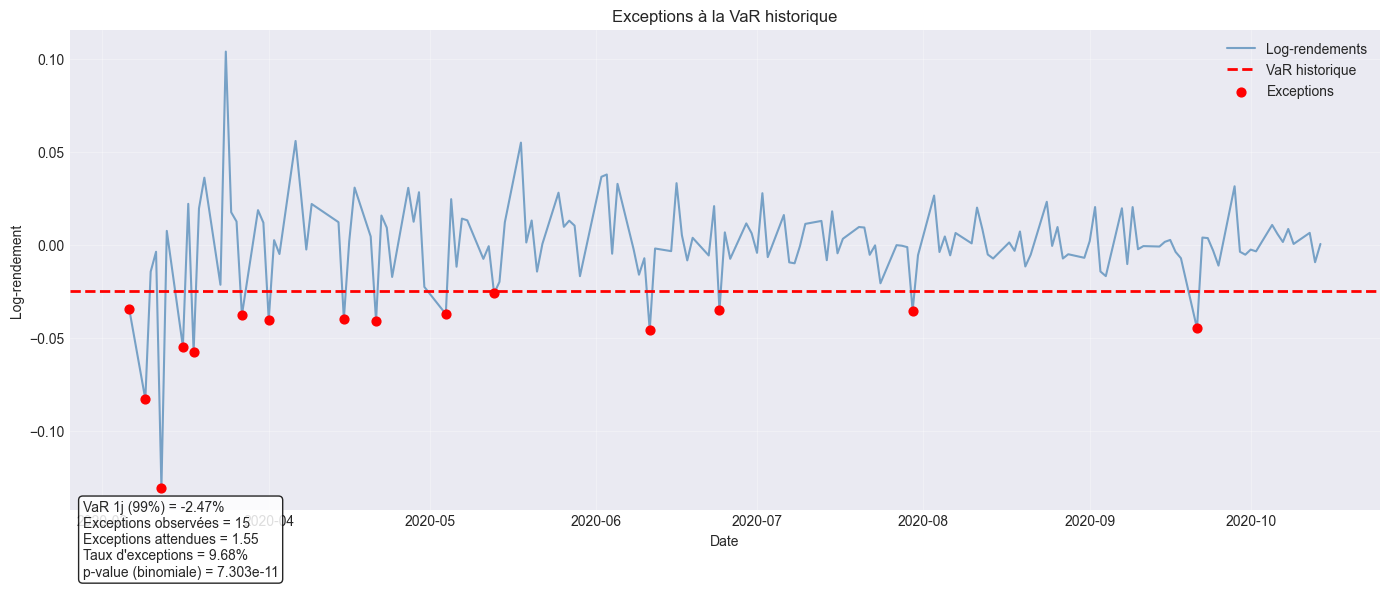

In [34]:
plot_exceptions(test.returns,alpha=0.99, var= var_hist,name='historique')

# 2.	VaR gaussienne

In [35]:
def VaR_Gauss(x, alpha, mu=None, sigma=None):
    """
    Calcule la Value at Risk (VaR) paramétrique gaussienne.
    
    Paramètres:
    -----------
    x : array-like
        Série des rendements logaritmiques
    alpha : float
        Niveau de confiance (ex: 0.95 pour 95%, 0.99 pour 99%)
    mu : float, optionnel
        Moyenne des rendements (si None, calculée à partir de x)
    sigma : float, optionnel
        Écart-type des rendements (si None, calculé à partir de x)

    Retourne:
    ---------
    float : VaR gaussienne au niveau alpha
    """
    # Conversion en array numpy et nettoyage
    x = np.asarray(x).flatten()
    x_clean = x[~np.isnan(x)]
    
    # Calcul des paramètres si non fournis
    if mu is None:
        mu = np.mean(x_clean)
    
    if sigma is None:
        sigma = np.std(x_clean, ddof=1)  # ddof=1 pour estimation non biaisée
    
    # Quantile de la distribution normale standard
    z_alpha = stats.norm.ppf(1 - alpha)
    
    # Formule de la VaR gaussienne
    var_gauss = mu + z_alpha * sigma
    
    return var_gauss,mu,sigma

In [36]:
var_gauss, mu,sigma = VaR_Gauss(train['returns'], alpha)
print(f'VaR gaussienne : {var_gauss:.6f}')

VaR gaussienne : -0.020468


### c.	Faire une validation ex-ante (analyses graphiques, QQ-plot, etc.)
Plusieurs tests de normalité (Shapiro–Wilk, Jarque–Bera, D’Agostino–Pearson, Anderson–Darling et Kolmogorov–Smirnov) sont utilisés afin d’évaluer la pertinence de l’hypothèse gaussienne, en portant une attention particulière au comportement en queue de distribution

In [37]:
def ex_ante_validation_gaussian(x, nom_variable='Returns'):
    """
    Ajuste une distribution gaussienne à un vecteur x
    et réalise plusieurs tests statistiques de normalité.
    """

    x = np.asarray(x)
    x = x[~np.isnan(x)]
    n = len(x)

    # 1. Estimation des paramètres
    mu_estime = np.mean(x)
    sigma_estime = np.std(x, ddof=1)

    print("\nVALIDATION EX-ANTE – AJUSTEMENT GAUSSIEN")
    print("=" * 50)
    print(f"Variable : {nom_variable}")
    print(f"Taille échantillon : n = {n}")
    print(f"μ estimé = {mu_estime:.6f}")
    print(f"σ estimé = {sigma_estime:.6f}")

    # 2. Tests de normalité
    print("\nTESTS DE NORMALITÉ")
    print("-" * 50)

    # Shapiro-Wilk
    shapiro_stat, shapiro_p = stats.shapiro(x)
    print(f"Shapiro-Wilk      : stat = {shapiro_stat:.4f}, p-value = {shapiro_p:.4f}")

    # Jarque-Bera
    jb_stat, jb_p = stats.jarque_bera(x)
    print(f"Jarque-Bera       : stat = {jb_stat:.4f}, p-value = {jb_p:.4f}")

    # D’Agostino-Pearson
    dag_stat, dag_p = stats.normaltest(x)
    print(f"D'Agostino-Pearson: stat = {dag_stat:.4f}, p-value = {dag_p:.4f}")

    # Anderson-Darling
    ad_result = stats.anderson(x, dist='norm')
    print("Anderson-Darling  :")
    print(f"  Statistique AD  = {ad_result.statistic:.4f}")
    for sl, cv in zip(ad_result.significance_level, ad_result.critical_values):
        decision = "Rejet" if ad_result.statistic > cv else "Non-rejet"
        print(f"  α = {sl:>4.1f}% | CV = {cv:.4f} → {decision}")

    # Kolmogorov-Smirnov
    ks_stat, ks_p = stats.kstest(x, 'norm', args=(mu_estime, sigma_estime))
    print(f"Kolmogorov-Smirnov: stat = {ks_stat:.4f}, p-value = {ks_p:.4f}")

    # 3. Graphiques
    fig = plt.figure(figsize=(14, 9))

    # Histogramme + densité gaussienne
    ax1 = plt.subplot(2, 2, 1)
    n_bins = min(50, int(np.sqrt(n)))
    ax1.hist(x, bins=n_bins, density=True, alpha=0.6,
             edgecolor='black', label='Histogramme')

    x_grid = np.linspace(x.min() - sigma_estime, x.max() + sigma_estime, 1000)
    pdf_gauss = stats.norm.pdf(x_grid, mu_estime, sigma_estime)
    ax1.plot(x_grid, pdf_gauss, 'r-', lw=2, label='Densité gaussienne')

    ax1.set_title(f'Histogramme et densité – {nom_variable}')
    ax1.set_xlabel('Valeur')
    ax1.set_ylabel('Densité')
    ax1.legend()
    ax1.grid(alpha=0.3)

    # QQ-plot
    ax2 = plt.subplot(2, 2, 2)
    stats.probplot(x, dist="norm", plot=ax2)
    ax2.set_title('QQ-plot vs loi normale')
    ax2.grid(alpha=0.3)

    # Fonction de répartition
    ax3 = plt.subplot(2, 2, 3)
    x_sorted = np.sort(x)
    fdr_emp = np.arange(1, n + 1) / n
    fdr_theo = stats.norm.cdf(x_sorted, mu_estime, sigma_estime)

    ax3.step(x_sorted, fdr_emp, where='post', lw=2, label='FDR empirique')
    ax3.plot(x_sorted, fdr_theo, 'r--', lw=2, label='FDR gaussienne')
    ax3.set_title('Fonction de répartition')
    ax3.set_xlabel('Valeur')
    ax3.set_ylabel('F(x)')
    ax3.legend()
    ax3.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    return {
        'mu': mu_estime,
        'sigma': sigma_estime,
        'n': n,
        'shapiro_stat': shapiro_stat,
        'shapiro_p': shapiro_p,
        'jb_stat': jb_stat,
        'jb_p': jb_p,
        'dagostino_stat': dag_stat,
        'dagostino_p': dag_p,
        'ad_stat': ad_result.statistic,
        'ks_stat': ks_stat,
        'ks_p': ks_p
    }



VALIDATION EX-ANTE – AJUSTEMENT GAUSSIEN
Variable : Returns
Taille échantillon : n = 926
μ estimé = 0.000244
σ estimé = 0.008903

TESTS DE NORMALITÉ
--------------------------------------------------
Shapiro-Wilk      : stat = 0.9754, p-value = 0.0000
Jarque-Bera       : stat = 161.0101, p-value = 0.0000
D'Agostino-Pearson: stat = 67.6190, p-value = 0.0000
Anderson-Darling  :
  Statistique AD  = 5.7140
  α = 15.0% | CV = 0.5740 → Rejet
  α = 10.0% | CV = 0.6530 → Rejet
  α =  5.0% | CV = 0.7840 → Rejet
  α =  2.5% | CV = 0.9140 → Rejet
  α =  1.0% | CV = 1.0870 → Rejet
Kolmogorov-Smirnov: stat = 0.0679, p-value = 0.0004


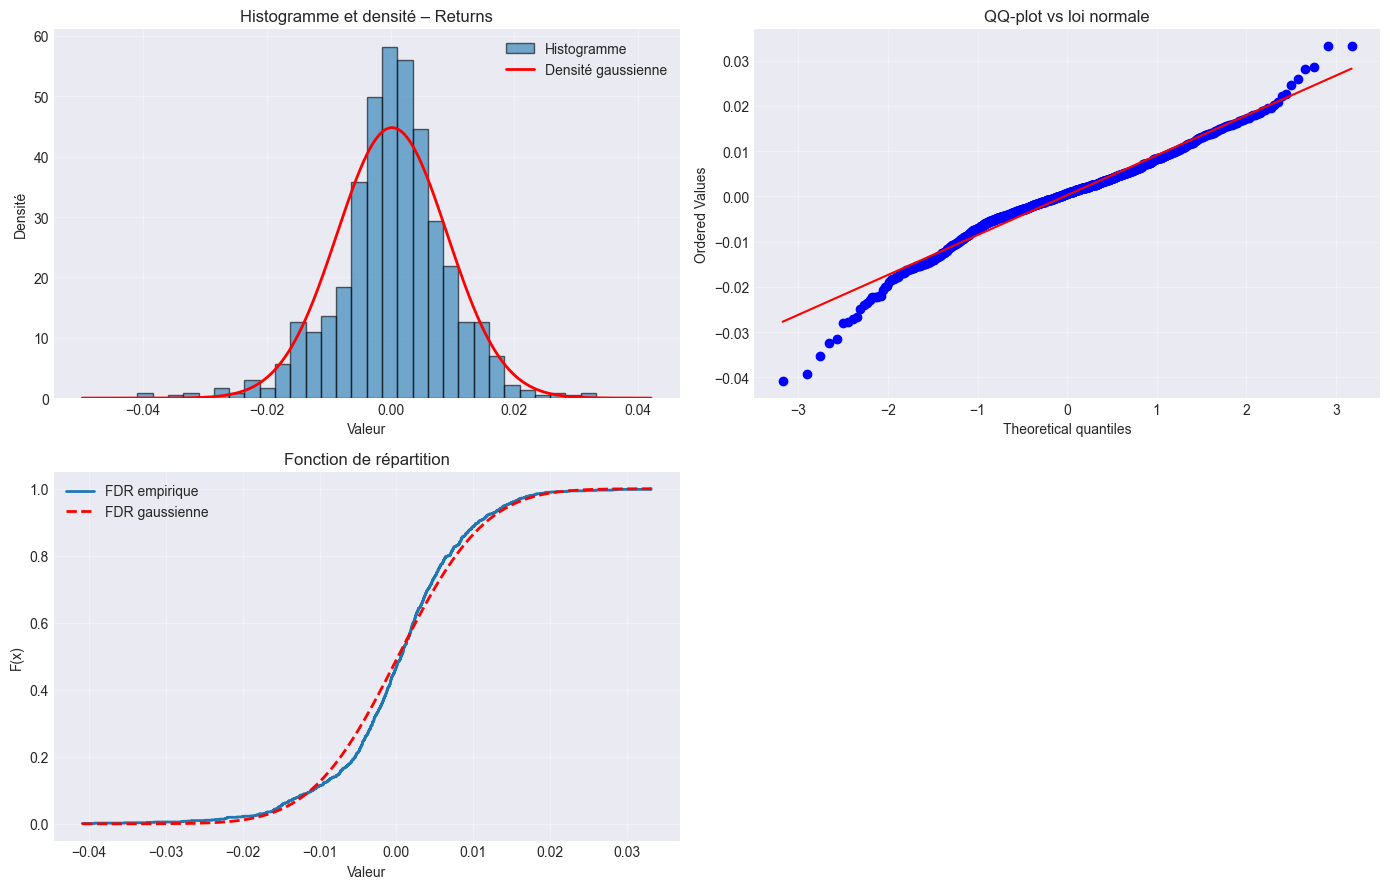

{'mu': np.float64(0.00024359689828045553),
 'sigma': np.float64(0.008902960892197236),
 'n': 926,
 'shapiro_stat': np.float64(0.9754302376717093),
 'shapiro_p': np.float64(2.160737665793983e-11),
 'jb_stat': np.float64(161.01006825498064),
 'jb_p': np.float64(1.0892007030611959e-35),
 'dagostino_stat': np.float64(67.61900522838515),
 'dagostino_p': np.float64(2.073574191185914e-15),
 'ad_stat': np.float64(5.714021678158133),
 'ks_stat': np.float64(0.0679194250428885),
 'ks_p': np.float64(0.0003698982162607956)}

In [38]:
ex_ante_validation_gaussian(train['returns'])

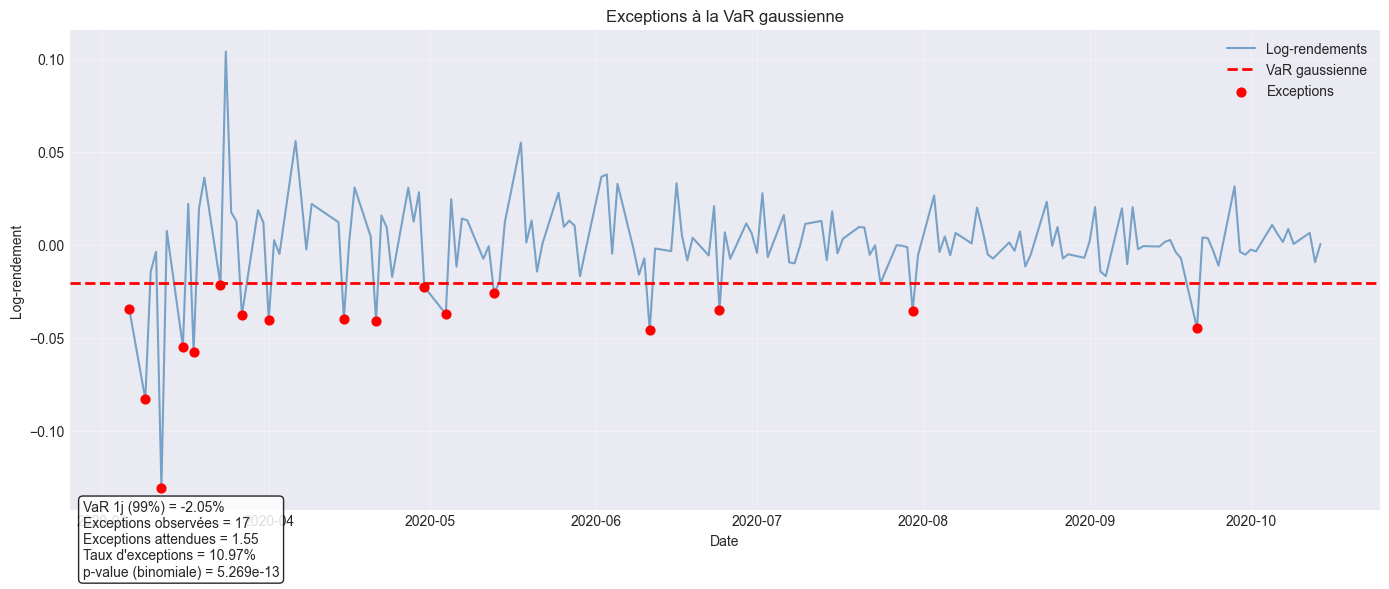

In [39]:
plot_exceptions(test.returns,alpha=0.99, var= var_gauss,name='gaussienne')

## e	Calculer la VaR gaussienne à 10j par méthode de diffusion d’un actif.
La VaR gaussienne à 10 jours est obtenue par la méthode du scaling, reposant sur l’hypothèse d’indépendance et de normalité des rendements, impliquant une croissance de la volatilité proportionnelle à la racine du temps.

On suppose que le prix de l’actif suit un processus de diffusion géométrique :

$$
dS_t = S_t \mu \, dt + S_t \sigma \sqrt{dt}\, Z_t,
\qquad Z_t \sim \mathcal{N}(0,1)
$$

Dans ce cadre, le log-prix suit un mouvement brownien avec dérive. Le log-rendement cumulé sur un horizon de $T$ jours vérifie alors :

$$
R_T =
\log S_{T} - \log S_0
\sim \mathcal{N}\left(
T\mu - \tfrac{1}{2} \cdot T \sigma^2,
\; T \sigma^2
\right)
$$

Donc :
$$
VaR_T^\alpha = T\mu - \tfrac{1}{2} \cdot T \sigma^2 + \sqrt T \sigma q_\alpha
$$

In [40]:
def VaR_Gauss_Diffusion(x, alpha=0.99, T=10):
    """
    VaR gaussienne à T jours par diffusion géométrique

    x     : série de log-rendements (1 jour)
    alpha : niveau de confiance
    T     : horizon (jours)
    """

    x = np.asarray(x)
    mu = np.mean(x)
    sigma = np.std(x, ddof=1)

    z_alpha = norm.ppf(alpha)

    var_T = -(
        T * mu
        - 0.5 * T * sigma**2
        + np.sqrt(T) * sigma * z_alpha
    )

    return var_T


In [41]:
VaR_10j =  VaR_Gauss_Diffusion(train.returns, alpha=0.99, T=10)
print(f"VaR gaussienne à 10 jours (diffusion) : {VaR_10j:.4%}")


VaR gaussienne à 10 jours (diffusion) : -6.7535%


In [42]:
# VaR 10 jours (scaling)
var_10j = np.sqrt(10) * var_gauss
print(f"VaR gaussienne, scaling à 10 jours (99%) : {var_10j:.4%}")

VaR gaussienne, scaling à 10 jours (99%) : -6.4725%


In [43]:
def VaR_Gauss_EWMA(x, alpha=0.99, lam=0.94):
    """
    VaR gaussienne à 1 jour avec EWMA

    x     : série de log-rendements (ordre chronologique)
    alpha : niveau de confiance
    lam   : paramètre lambda (0 < lam < 1)
    """

    x = np.asarray(x)
    T = len(x) - 1

    # Poids EWMA (i = 0 correspond à l'observation la plus récente)
    weights = np.array([(1 - lam) * lam**i for i in range(T + 1)])

    # Normalisation
    weights = weights / weights.sum()

    # Rendements récents en premier
    x_rev = x[::-1]

    # Moyenne pondérée
    mu_hat = np.sum(weights * x_rev)

    # Variance pondérée
    sigma2_hat = np.sum(weights * (x_rev - mu_hat)**2)
    sigma_hat = np.sqrt(sigma2_hat)

    # Quantile gaussien
    z_alpha = norm.ppf(1-alpha)

    # VaR EWMA 1 jour
    var_ewma = mu_hat + sigma_hat * z_alpha

    return var_ewma, mu_hat, sigma_hat


## f. La VaR gaussienne EWMA


La méthode EWMA (Exponential Weighting Moving Average) consiste à estimer les paramètres de la loi gaussienne des rendements en surpondérant les observations les plus récentes à l’aide de poids exponentiellement décroissants. Cette approche permet de rendre la VaR plus réactive aux changements récents de volatilité du marché.

La VaR gaussienne à 1 jour est alors calculée à partir de la moyenne et de l’écart-type pondérés estimés par EWMA.

---

### Résultats – VaR gaussienne EWMA (1 jour, α = 99 %)

| λ    | μ̂(λ)      | σ̂²(λ)     | VaR EWMA 1j (99 %) |
|-----:|-----------:|-----------:|-------------------:|
| 0.90 | -0.006993  | 0.000277   | -4.5723 % |
| 0.95 | -0.004452  | 0.000224   | -3.9291 % |
| 0.99 | -0.000627  | 0.000118   | -2.5926 % |


In [44]:
EWMA = {}
for lam in [0.9, 0.95, 0.99]:
    var, mu_hat, sigma_hat = VaR_Gauss_EWMA(train.returns, alpha=0.99, lam=lam)
    print(f"λ = {lam}")
    print(f"  μ̂(λ) = {mu_hat:.6f}")
    print(f"  σ̂²(λ) = {sigma_hat**2:.6f}")
    print(f"  VaR EWMA 1j (99%) = {var:.4%}\n")
    EWMA[lam] = {
        'var':var,
        'mu' : mu_hat,
        'sigma': sigma_hat
    }


λ = 0.9
  μ̂(λ) = -0.006993
  σ̂²(λ) = 0.000277
  VaR EWMA 1j (99%) = -4.5723%

λ = 0.95
  μ̂(λ) = -0.004452
  σ̂²(λ) = 0.000224
  VaR EWMA 1j (99%) = -3.9291%

λ = 0.99
  μ̂(λ) = -0.000627
  σ̂²(λ) = 0.000118
  VaR EWMA 1j (99%) = -2.5926%



In [45]:
alpha = 0.99
for lamb in EWMA :
    var = EWMA[lamb]['var']
    dic = count_exceptions(test.returns,var_value=var,alpha=0.99)
    EWMA[lamb]['n_exceptions'] = dic['n_exceptions']
    EWMA[lamb]['exception_rate'] = dic['exception_rate']
    EWMA[lamb]['expected_exceptions'] = dic['expected_exceptions']
    EWMA[lamb]['binom_test'] =  dic['binom_test']
    




In [46]:
def plot_ewma_exceptions(returns_test, ewma_dict, lambda_):
    """
    Visualise les rendements, la VaR EWMA et les exceptions
    pour une valeur donnée de lambda
    """
    
    stats = ewma_dict[lambda_]
    var = stats['var']
    
    # Identification des exceptions
    exceptions = returns_test[returns_test < var]
    
    plt.figure(figsize=(14, 6))
    
    # Rendements
    plt.plot(returns_test.index, returns_test.values,
             label='Log-rendements', color='steelblue', alpha=0.7)
    
    # VaR
    plt.axhline(var, color='red', linestyle='--',
                linewidth=2, label=f'VaR EWMA (λ={lambda_})')
    
    # Exceptions
    plt.scatter(exceptions.index, exceptions.values,
                color='red', s=40, zorder=3, label='Exceptions')
    
    # Texte statistiques
    textstr = (
        f"λ = {lambda_}\n"
        f"μ̂ = {stats['mu']:.5f}\n"
        f"σ̂ = {stats['sigma']:.5f}\n"
        f"VaR 1j (99%) = {var:.2%}\n"
        f"Exceptions observées = {stats['n_exceptions']}\n"
        f"Exceptions attendues = {stats['expected_exceptions']:.2f}\n"
        f"Taux d'exceptions = {stats['exception_rate']:.2%}\n"
        f"p-value (binomiale) = {stats['binom_test'].pvalue:.4g}"
    )
    
    plt.gca().text(
        0.01, 0.02, textstr,
        transform=plt.gca().transAxes,
        fontsize=10,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.85)
    )
    
    plt.title(f"Exceptions à la VaR gaussienne EWMA (λ = {lambda_})")
    plt.xlabel("Date")
    plt.ylabel("Log-rendement")
    plt.legend()
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()


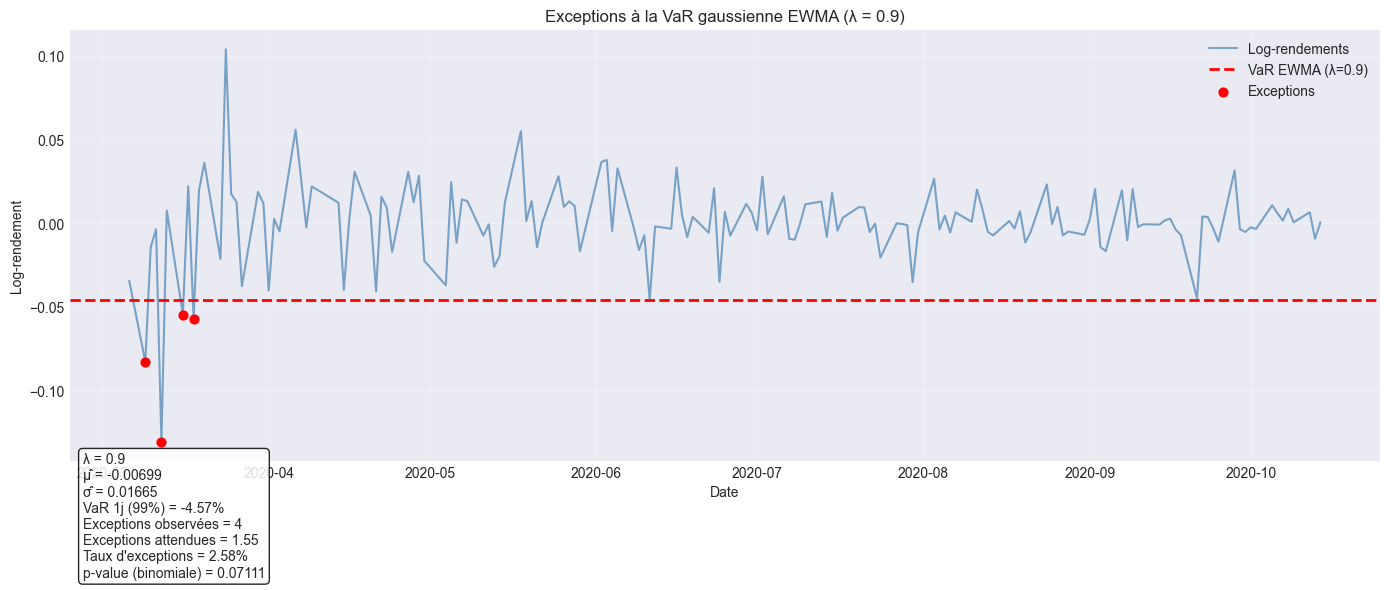

In [47]:
plot_ewma_exceptions(test.returns, EWMA, 0.9)

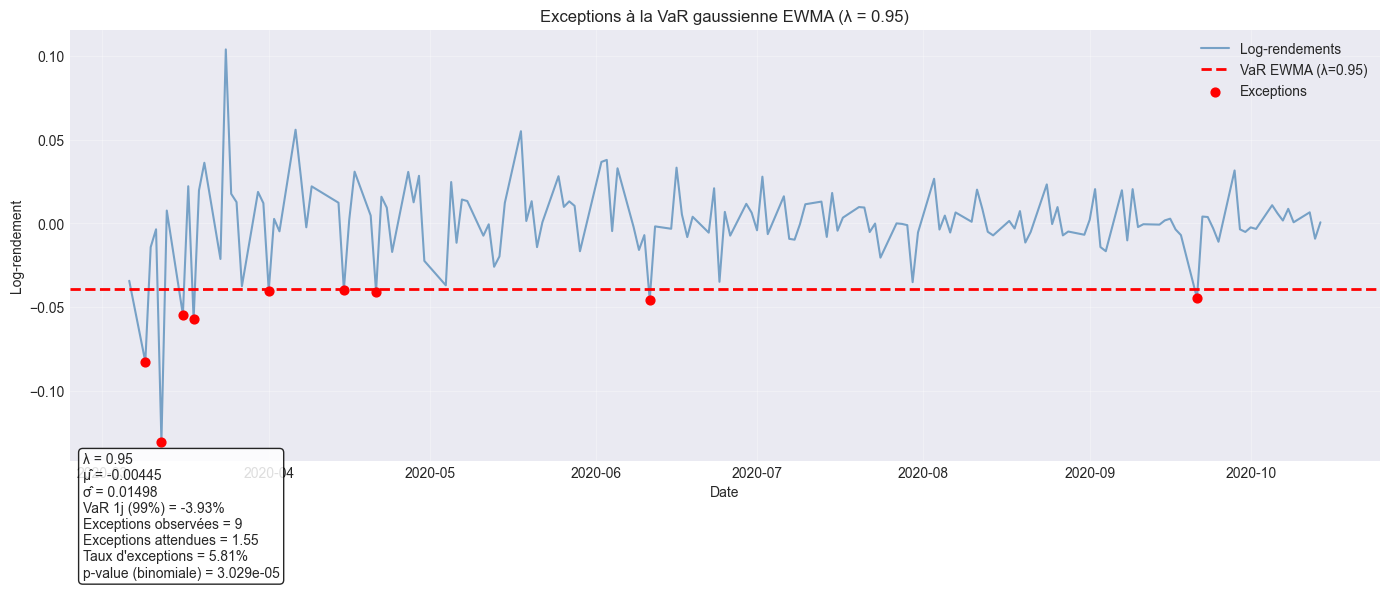

In [48]:
plot_ewma_exceptions(test.returns, EWMA, 0.95)

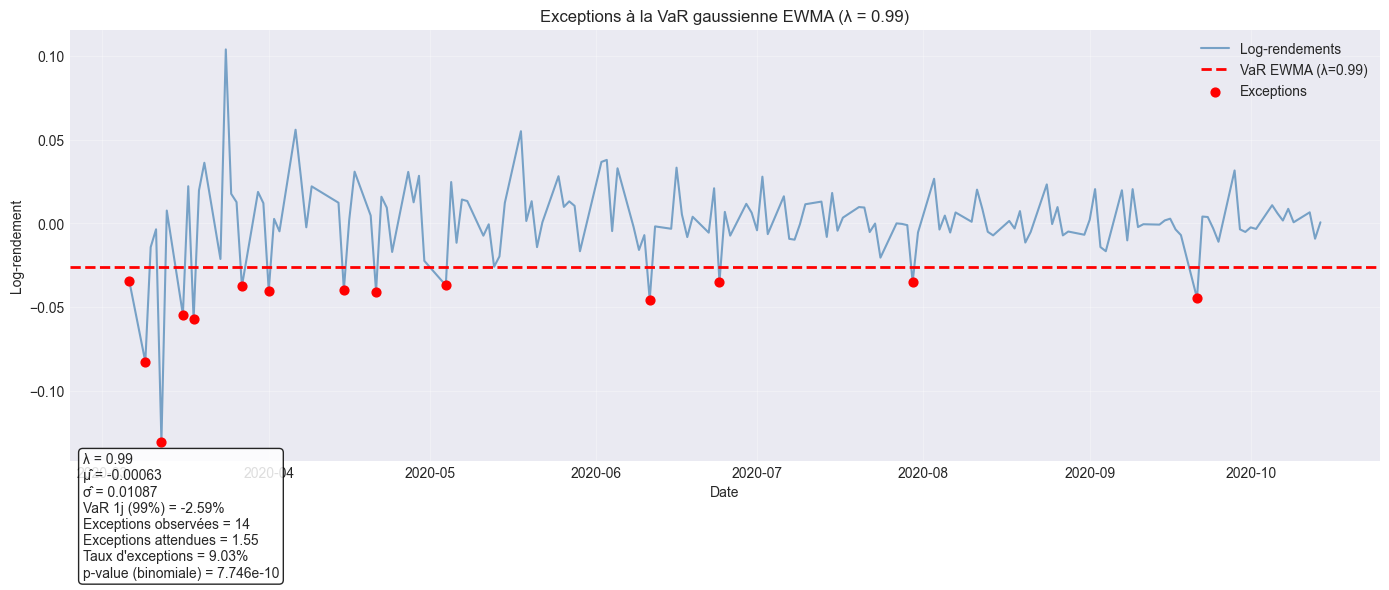

In [49]:
plot_ewma_exceptions(test.returns, EWMA, 0.99)

# 3.	VaR skew-Student

### VaR par loi de Skew-Student

Les rendements financiers présentent généralement une asymétrie et des queues épaisses, ce qui rend l’hypothèse gaussienne souvent inadéquate. Afin de mieux capturer ces caractéristiques, on modélise les log-rendements par une loi de Skew-Student.

La densité de la loi de Skew-Student (Azzalini) s’écrit :
$$
f(x) = \frac{2}{\sigma}
\, t_\nu\!\left( \frac{x-\mu}{\sigma} \right)
\, T_{\nu+1}\!\left(
\alpha \frac{x-\mu}{\sigma}
\sqrt{\frac{\nu+1}{\nu + \left(\frac{x-\mu}{\sigma}\right)^2}}
\right),
$$
où $t_\nu$ désigne la densité de Student à $\nu$ degrés de liberté et $T_{\nu+1}$ sa fonction de répartition.

Les paramètres $\mu$ (localisation), $\sigma$ (échelle), $\nu$ (degrés de liberté) et $\alpha$ (asymétrie) sont estimés par maximum de vraisemblance à partir de l’échantillon d’apprentissage, en maximisant la log-vraisemblance associée à la densité précédente.

La qualité de l’ajustement est évaluée par des outils graphiques, notamment le QQ-plot, et comparée à celle obtenue sous l’hypothèse gaussienne. La VaR à 99 % est ensuite calculée à partir du quantile de la loi de Skew-Student ajustée, permettant une meilleure prise en compte du risque extrême.


In [50]:
def skew_student_pdf(x, mu, sigma, nu, alpha):
    """
    Densité de la loi Skew-Student (Azzalini)
    """
    z = (x - mu) / sigma
    
    t_pdf = stats.t.pdf(z, df=nu)
    t_cdf = stats.t.cdf(
        alpha * z * np.sqrt((nu + 1) / (nu + z**2)),
        df=nu + 1
    )
    
    return 2 / sigma * t_pdf * t_cdf


In [51]:
def skew_student_loglik(params, x):
    """
    Log-vraisemblance de la Skew-Student
    """
    mu, sigma, nu, alpha = params
    
    # Contraintes
    if sigma <= 0 or nu <= 2:
        return np.inf
    
    pdf_vals = skew_student_pdf(x, mu, sigma, nu, alpha)
    
    # Sécurité numérique
    if np.any(pdf_vals <= 0):
        return np.inf
    
    return -np.sum(np.log(pdf_vals))


In [52]:
def estimate_skew_student_mle(x,init_params=None):
    """
    Estimation MLE des paramètres Skew-Student
    """
    if not init_params:
        # Initialisation raisonnable
        mu0 = np.mean(x)
        sigma0 = np.std(x)
        nu0 = 8.0
        alpha0 = 0.0
        
        init_params = [mu0, sigma0, nu0, alpha0]
        
    bounds = [
        (None, None),   # mu
        (1e-6, None),   # sigma
        (2.01, 100),    # nu
        (None, None)    # alpha
    ]
    
    result = minimize(
        skew_student_loglik,
        init_params,
        args=(x,),
        method='L-BFGS-B',
        bounds=bounds
    )
    
    if not result.success:
        raise RuntimeError("Optimisation échouée")
    
    mu_hat, sigma_hat, nu_hat, alpha_hat = result.x
    print(result.message)
    print('Convergence?:', result.success)
    
    return {
        'mu': mu_hat,
        'sigma': sigma_hat,
        'nu': nu_hat,
        'alpha': alpha_hat,
        'loglik': -result.fun
    }


## b.	Estimer les paramètres de loi Skew Student sur base d’apprentissage

In [53]:
params_skew = estimate_skew_student_mle(train.returns)

params_skew


CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
Convergence?: True


{'mu': np.float64(0.00048603702741480224),
 'sigma': np.float64(0.007491117217702084),
 'nu': np.float64(8.00000001556615),
 'alpha': np.float64(-9.95351341535208e-07),
 'loglik': np.float64(3086.0405449312134)}

## Validation ex-ante – QQ-plot Skew-Student

La validation ex-ante du modèle Skew-Student est réalisée à l’aide d’un QQ-plot, qui compare les quantiles empiriques des log-rendements observés aux quantiles théoriques de la loi de Skew-Student ajustée sur l’échantillon d’apprentissage.

Si le modèle est bien spécifié, les points du QQ-plot doivent être approximativement alignés sur la droite de référence. Les écarts observés dans les queues permettent d’évaluer la capacité du modèle à capturer les comportements extrêmes, élément essentiel dans le cadre du calcul de la Value-at-Risk.

Les quantiles théoriques de la loi de Skew-Student ne disposant pas d’expression analytique fermée, ceux-ci sont approchés par simulation Monte-Carlo à partir d’une construction asymétrique de la loi de Student.



In [54]:
def qqplot_skew_student(x, params):
    """
    QQ-plot pour la loi Skew-Student
    """
    mu = params['mu']
    sigma = params['sigma']
    nu = params['nu']
    alpha = params['alpha']
    
    # Quantiles empiriques
    x_sorted = np.sort(x)
    n = len(x_sorted)
    probs = (np.arange(1, n + 1) - 0.5) / n
    
    # Quantiles théoriques via simulation
    # (plus stable qu'une inversion analytique)
    sim = stats.t.rvs(df=nu, size=200000)
    sim = mu + sigma * (sim + alpha * np.abs(sim))
    q_theoretical = np.quantile(sim, probs)
    
    # QQ-plot
    plt.figure(figsize=(6, 6))
    plt.scatter(q_theoretical, x_sorted, alpha=0.6)
    plt.plot(
        [q_theoretical.min(), q_theoretical.max()],
        [q_theoretical.min(), q_theoretical.max()],
        'r--', linewidth=2
    )
    
    plt.xlabel("Quantiles théoriques Skew-Student")
    plt.ylabel("Quantiles empiriques")
    plt.title("QQ-plot – Validation ex-ante Skew-Student")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


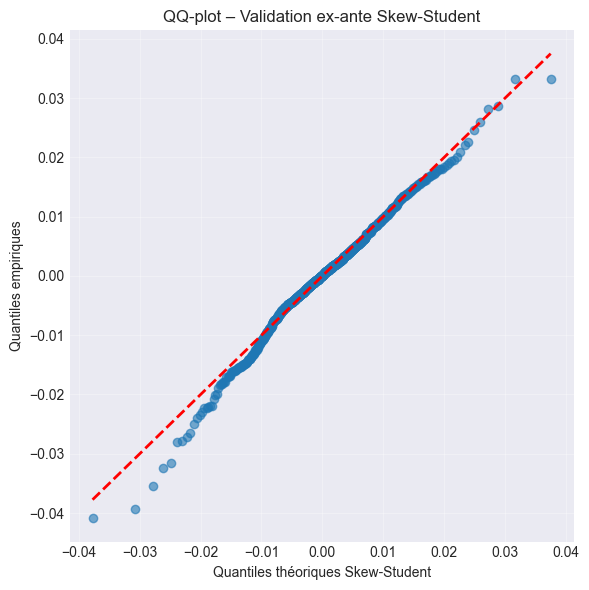

In [55]:
qqplot_skew_student(train.returns, params_skew)


Des écarts sont observés dans les quantiles extrêmes, suggérant une sous-estimation du risque de queue. Néanmoins, la loi de Skew-Student améliore significativement l’ajustement par rapport à l’hypothèse gaussienne.


### Comparaison de la qualité d’ajustement : Gaussienne vs Skew-Student

La qualité d’ajustement des modèles gaussien et Skew-Student est comparée à l’aide d’outils graphiques. Les densités théoriques ajustées sont superposées à l’histogramme des log-rendements, et les QQ-plots correspondants sont analysés.

La loi gaussienne permet de capturer le comportement central des rendements mais sous-estime généralement l’épaisseur des queues. À l’inverse, la loi de Skew-Student offre une meilleure flexibilité grâce à ses paramètres d’asymétrie et de degrés de liberté, permettant un meilleur ajustement des rendements extrêmes.


In [56]:
def compare_densities_gauss_skew(x, params_gauss, params_skew):
    """
    Comparaison graphique des densités gaussienne et Skew-Student
    """
    mu_g, sigma_g = params_gauss['mu'], params_gauss['sigma']
    
    mu_s = params_skew['mu']
    sigma_s = params_skew['sigma']
    nu_s = params_skew['nu']
    alpha_s = params_skew['alpha']
    
    x_grid = np.linspace(np.min(x), np.max(x), 1000)
    
    # Histogramme
    plt.figure(figsize=(10, 6))
    plt.hist(x, bins=40, density=True, alpha=0.5,
             label='Histogramme des rendements')
    
    # Densité gaussienne
    plt.plot(
        x_grid,
        stats.norm.pdf(x_grid, mu_g, sigma_g),
        'r--', linewidth=2, label='Gaussienne'
    )
    
    # Densité Skew-Student
    from scipy.stats import t
    
    z = (x_grid - mu_s) / sigma_s
    pdf_skew = (
        2 / sigma_s
        * t.pdf(z, df=nu_s)
        * t.cdf(
            alpha_s * z * np.sqrt((nu_s + 1) / (nu_s + z**2)),
            df=nu_s + 1
        )
    )
    
    plt.plot(
        x_grid,
        pdf_skew,
        'g-', linewidth=2, label='Skew-Student'
    )
    
    plt.title("Comparaison des densités ajustées")
    plt.xlabel("Log-rendement")
    plt.ylabel("Densité")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


In [57]:
def qqplot_gauss_vs_skew(x, params_gauss, params_skew):
    """
    QQ-plots comparés Gaussienne vs Skew-Student
    """
    x_sorted = np.sort(x)
    n = len(x_sorted)
    probs = (np.arange(1, n + 1) - 0.5) / n
    
    # Gaussienne
    q_gauss = stats.norm.ppf(probs, params_gauss['mu'], params_gauss['sigma'])
    
    # Skew-Student (simulation)
    sim = stats.t.rvs(df=params_skew['nu'], size=200000)
    sim = params_skew['mu'] + params_skew['sigma'] * (
        sim + params_skew['alpha'] * np.abs(sim)
    )
    q_skew = np.quantile(sim, probs)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # QQ Gauss
    axes[0].scatter(q_gauss, x_sorted, alpha=0.6)
    axes[0].plot(
        [q_gauss.min(), q_gauss.max()],
        [q_gauss.min(), q_gauss.max()],
        'r--'
    )
    axes[0].set_title("QQ-plot Gaussienne")
    axes[0].set_xlabel("Quantiles théoriques")
    axes[0].set_ylabel("Quantiles empiriques")
    axes[0].grid(alpha=0.3)
    
    # QQ Skew
    axes[1].scatter(q_skew, x_sorted, alpha=0.6)
    axes[1].plot(
        [q_skew.min(), q_skew.max()],
        [q_skew.min(), q_skew.max()],
        'r--'
    )
    axes[1].set_title("QQ-plot Skew-Student")
    axes[1].set_xlabel("Quantiles théoriques")
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()


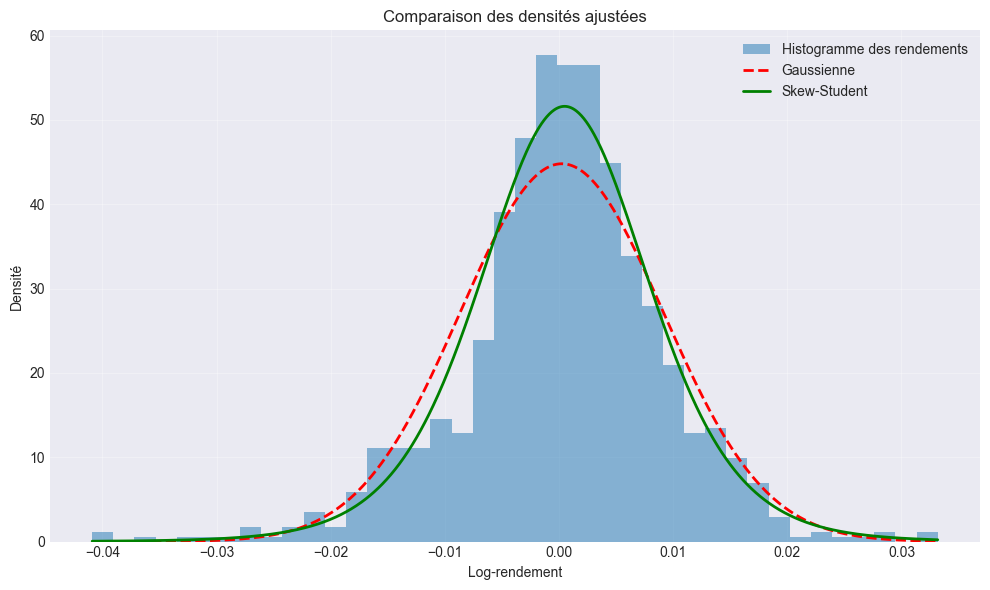

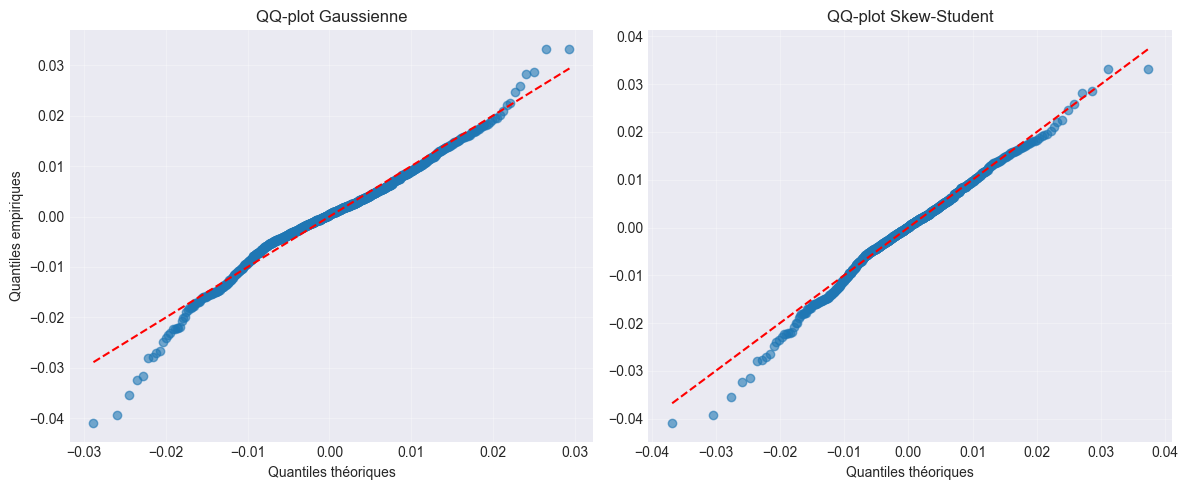

In [58]:
params_gauss ={}
params_gauss['mu'], params_gauss['sigma'] = mu, sigma
compare_densities_gauss_skew(train.returns, params_gauss, params_skew)
qqplot_gauss_vs_skew(train.returns, params_gauss, params_skew)

L’analyse graphique met en évidence une nette amélioration de la qualité d’ajustement avec la loi de Skew-Student. Alors que le modèle gaussien sous-estime les quantiles extrêmes, la Skew-Student permet de mieux reproduire l’asymétrie et l’épaisseur des queues observées dans les rendements, ce qui justifie son utilisation pour le calcul de la Value-at-Risk.


## e.	Calculer la VaR Skew Student sur base d’apprentissage pour alpha = 99%.

In [59]:
def var_skew_student(params,alpha = 0.99,size=200000):
    """
    QQ-plot pour la loi Skew-Student
    """

    mu = params['mu']
    sigma = params['sigma']
    nu = params['nu']
    alpha_t = params['alpha']
    
    # Quantiles théoriques via simulation
    # (plus stable qu'une inversion analytique)
    sim = stats.t.rvs(df=nu, size=size)
    sim = mu + sigma * (sim + alpha_t * np.abs(sim))
    var = np.quantile(sim, 1-alpha)
    return var

In [60]:
var_skew_t = var_skew_student(params_skew,alpha = 0.99,size=200000)

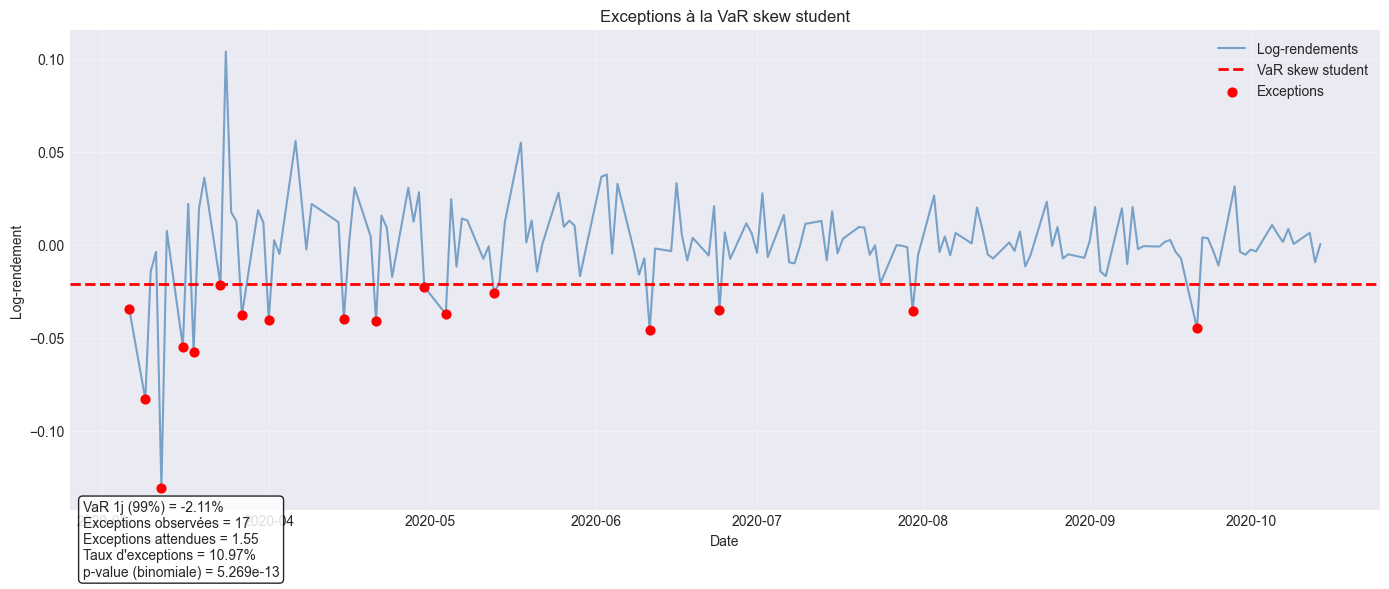

In [61]:
plot_exceptions(test.returns,alpha=0.99, var= var_skew_t,name='skew student')

# KDE

In [62]:
def kde_gaussien_complet(x, nom_variable="returns", bandwidth=None):
    """
    Estimation par noyaux gaussiens (Kernel Density Estimation)
    avec noyau gaussien et sélection automatique de la bande passante
    """
    
    n = len(x)
    mu_emp = np.mean(x)
    sigma_emp = np.std(x)
    
    print(f"KDE AVEC NOYAU GAUSSIEN - {nom_variable}")
    print(f"Moyenne empirique: {mu_emp:.6f}")
    print(f"Écart-type empirique: {sigma_emp:.6f}")
    print(f"Médiane: {np.median(x):.6f}")
    print(f"Min: {np.min(x):.6f}, Max: {np.max(x):.6f}")
    print(f"IQR: {np.percentile(x, 75) - np.percentile(x, 25):.6f}")
    
    # Création de l'objet KDE
    if bandwidth is None:
        # Règle de Silverman pour la bande passante
        h_silverman = 1.06 * sigma_emp * n**(-1/5)
        bandwidth = h_silverman
    
    kde = stats.gaussian_kde(x, bw_method=bandwidth/sigma_emp if sigma_emp > 0 else 0.1)
    kde_bandwidth = kde.factor * sigma_emp if sigma_emp > 0 else kde.factor
    
    print(f"\nPARAMÈTRES KDE:")
    print(f"Bande passante (bandwidth): {kde_bandwidth:.6f}")
    print(f"Bande passante relative (factor): {kde.factor:.6f}")
    print(f"Méthode: Noyau gaussien")
    
    # Calcul sur une grille
    x_min, x_max = np.min(x) - 3*kde_bandwidth, np.max(x) + 3*kde_bandwidth
    x_grid = np.linspace(x_min, x_max, 1000)
    kde_values = kde(x_grid)
    
    # Calcul de moments à partir de KDE
    def moments_from_kde(kde_obj, n_moments=4):
        """Calcule les moments à partir de la densité KDE"""
        # On utilise l'intégration numérique
        x_integ = np.linspace(x_min, x_max, 2000)
        pdf_integ = kde_obj(x_integ)
        dx = x_integ[1] - x_integ[0]
        
        # Normalisation
        norm = np.sum(pdf_integ) * dx
        
        if norm > 0:
            # Moyenne
            mean_kde = np.sum(x_integ * pdf_integ) * dx / norm
            
            # Variance
            var_kde = np.sum((x_integ - mean_kde)**2 * pdf_integ) * dx / norm
            
            # Skewness
            skew_kde = np.sum((x_integ - mean_kde)**3 * pdf_integ) * dx / norm / (var_kde**1.5)
            
            # Kurtosis
            kurt_kde = np.sum((x_integ - mean_kde)**4 * pdf_integ) * dx / norm / (var_kde**2)
            
            return mean_kde, var_kde, skew_kde, kurt_kde
        return None, None, None, None
    
    mean_kde, var_kde, skew_kde, kurt_kde = moments_from_kde(kde)
    
    if mean_kde is not None:
        print(f"\nMOMENTS ESTIMÉS PAR KDE:")
        print(f"Moyenne KDE: {mean_kde:.6f}")
        print(f"Variance KDE: {var_kde:.6f} (σ = {np.sqrt(var_kde):.6f})")
        print(f"Asymétrie KDE: {skew_kde:.6f}")
        print(f"Kurtosis KDE: {kurt_kde:.6f}")
    
    # 2. Graphiques
    fig = plt.figure(figsize=(15, 10))
    
    # 2a. Comparaison avec histogramme et densité normale
    ax1 = plt.subplot(2, 2, 1)
    
    # Histogramme
    n_bins = min(50, int(np.sqrt(n)))
    ax1.hist(x, bins=n_bins, density=True, alpha=0.3, color='gray', 
             edgecolor='black', label='Histogramme')
    
    # KDE
    ax1.plot(x_grid, kde_values, 'b-', linewidth=3, label=f'KDE (h={kde_bandwidth:.3f})')
    
    # Densité normale
    pdf_norm = stats.norm.pdf(x_grid, loc=mu_emp, scale=sigma_emp)
    ax1.plot(x_grid, pdf_norm, 'r--', linewidth=2, alpha=0.7, label='Normale empirique')
    
    # Points de données (rug plot)
    ax1.plot(x, np.zeros_like(x) - 0.001, '|', color='black', alpha=0.1, markersize=10)
    
    ax1.set_xlabel('Valeur')
    ax1.set_ylabel('Densité')
    ax1.set_title(f'Estimation par noyaux gaussiens - {nom_variable}')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2b. Effet de la bande passante
    ax2 = plt.subplot(2, 2, 2)
    
    # Différentes bandes passantes
    bandwidths = [kde_bandwidth * 0.5, kde_bandwidth, kde_bandwidth * 2]
    colors = ['green', 'blue', 'red']
    labels = [f'h={h:.3f}' for h in bandwidths]
    
    for h, color, label in zip(bandwidths, colors, labels):
        kde_temp = stats.gaussian_kde(x, bw_method=h/sigma_emp if sigma_emp > 0 else h)
        ax2.plot(x_grid, kde_temp(x_grid), color=color, linewidth=2, 
                label=label, alpha=0.7)
    
    ax2.hist(x, bins=n_bins, density=True, alpha=0.1, color='gray', edgecolor='black')
    ax2.plot(x, np.zeros_like(x) - 0.001, '|', color='black', alpha=0.05, markersize=10)
    
    ax2.set_xlabel('Valeur')
    ax2.set_ylabel('Densité')
    ax2.set_title('Effet de la bande passante')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 2c. Fonction de répartition KDE vs empirique
    ax3 = plt.subplot(2, 2, 3)
    
    # FDR empirique
    x_sorted = np.sort(x)
    fdr_emp = np.arange(1, n + 1) / n
    
    # FDR KDE (intégration numérique)
    fdr_kde = np.zeros_like(x_grid)
    for i in range(len(x_grid)):
        fdr_kde[i] = np.trapz(kde_values[:i+1], x_grid[:i+1])
    
    # Normalisation de la FDR KDE
    fdr_kde = fdr_kde / fdr_kde[-1] if fdr_kde[-1] > 0 else fdr_kde
    
    ax3.step(x_sorted, fdr_emp, 'k-', where='post', linewidth=1, label='FDR empirique')
    ax3.plot(x_grid, fdr_kde, 'b-', linewidth=2, label='FDR KDE')
    
    # FDR normale
    fdr_norm = stats.norm.cdf(x_grid, loc=mu_emp, scale=sigma_emp)
    ax3.plot(x_grid, fdr_norm, 'r--', linewidth=2, alpha=0.7, label='FDR normale')
    
    ax3.set_xlabel('Valeur')
    ax3.set_ylabel('Fonction de répartition')
    ax3.set_title('Fonctions de répartition comparées')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 2d. Analyse des résidus et qualité de l'ajustement
    ax4 = plt.subplot(2, 2, 4)
    
    # Calcul de la FDR KDE aux points empiriques
    fdr_kde_at_points = np.interp(x_sorted, x_grid, fdr_kde)
    residuals = fdr_emp - fdr_kde_at_points
    
    ax4.plot(x_sorted, residuals, 'g-', linewidth=1)
    ax4.fill_between(x_sorted, 0, residuals, where=residuals>0, 
                     alpha=0.3, color='green', label='KDE sous-estime')
    ax4.fill_between(x_sorted, 0, residuals, where=residuals<0, 
                     alpha=0.3, color='red', label='KDE sur-estime')
    ax4.axhline(y=0, color='k', linestyle='--', alpha=0.5)
    
    # Statistique de Kolmogorov-Smirnov
    ks_stat = np.max(np.abs(residuals))
    ax4.axhline(y=ks_stat, color='b', linestyle=':', alpha=0.5, 
                label=f'KS = {ks_stat:.3f}')
    ax4.axhline(y=-ks_stat, color='b', linestyle=':', alpha=0.5)
    
    ax4.set_xlabel('Valeur')
    ax4.set_ylabel('FDR empirique - FDR KDE')
    ax4.set_title(f'Résidus de l\'ajustement KDE')
    ax4.legend(loc='best')
    ax4.grid(True, alpha=0.3)
    
    plt.suptitle(f'KDE avec noyau gaussien - {nom_variable} (n={n}, h={kde_bandwidth:.3f})', 
                 fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # 3. Métriques de performance
    print(f"\nQUALITÉ DE L'AJUSTEMENT KDE:")
    print("-" * 40)
    
    # Intégrated Squared Error (ISE) approximé
    dx = x_grid[1] - x_grid[0]
    
    # Densité empirique (histogramme)
    hist, bin_edges = np.histogram(x, bins=n_bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    pdf_hist = np.interp(x_grid, bin_centers, hist)
    
    ise = np.sum((kde_values - pdf_hist)**2) * dx
    print(f"Integrated Squared Error (ISE): {ise:.6f}")
    
    # Statistique KS
    print(f"Statistique Kolmogorov-Smirnov: {ks_stat:.6f}")
    
    # Score de vraisemblance log
    log_likelihood = np.sum(np.log(kde(x) + 1e-10))
    print(f"Log-vraisemblance: {log_likelihood:.2f}")
    
    # 4. Comparaison avec la distribution normale
    print(f"\nCOMPARAISON KDE vs DISTRIBUTION NORMALE:")
    print("-" * 40)
    
    # Différence intégrée
    diff_integrale = np.sum(np.abs(kde_values - pdf_norm)) * dx
    print(f"Différence intégrée L1: {diff_integrale:.6f}")
    
    # Ratio de vraisemblance
    log_lik_norm = np.sum(stats.norm.logpdf(x, loc=mu_emp, scale=sigma_emp))
    print(f"Log-vraisemblance Normale: {log_lik_norm:.2f}")
    print(f"Différence de log-vraisemblance: {log_likelihood - log_lik_norm:.2f}")
    
    if log_likelihood > log_lik_norm:
        print("→ KDE a une meilleure vraisemblance que la normale")
    else:
        print("→ La normale a une meilleure vraisemblance que KDE")
    
    # 5. Estimation des quantiles avec KDE
    print(f"\nESTIMATION DES QUANTILES PAR KDE:")
    print("-" * 40)
    
    quantiles = [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]
    
    print(f"{'Quantile':<10} {'KDE':<12} {'Empirique':<12} {'Normale':<12}")
    print("-" * 50)
    
    for q in quantiles:
        # Quantile empirique
        q_emp = np.percentile(x, q * 100)
        
        # Quantile KDE (par interpolation inverse de la FDR)
        idx = np.argmax(fdr_kde >= q)
        if idx > 0:
            q_kde = x_grid[idx]
        else:
            q_kde = np.interp(q, fdr_kde, x_grid)
        
        # Quantile normale
        q_norm = stats.norm.ppf(q, loc=mu_emp, scale=sigma_emp)
        
        print(f"{q*100:>5.1f}%   {q_kde:11.6f}  {q_emp:11.6f}  {q_norm:11.6f}")
    
    return {
        'kde_object': kde,
        'bandwidth': kde_bandwidth,
        'x_grid': x_grid,
        'kde_values': kde_values,
        'fdr_kde': fdr_kde,
        'mean_kde': mean_kde,
        'var_kde': var_kde,
        'skew_kde': skew_kde,
        'kurt_kde': kurt_kde,
        'log_likelihood': log_likelihood,
        'ks_stat': ks_stat,
        'ise': ise
    }


KDE AVEC NOYAU GAUSSIEN - returns
Moyenne empirique: 0.000244
Écart-type empirique: 0.008898
Médiane: 0.000650
Min: -0.040892, Max: 0.033175
IQR: 0.009459

PARAMÈTRES KDE:
Bande passante (bandwidth): 0.002406
Bande passante relative (factor): 0.270386
Méthode: Noyau gaussien

MOMENTS ESTIMÉS PAR KDE:
Moyenne KDE: 0.000244
Variance KDE: 0.000085 (σ = 0.009218)
Asymétrie KDE: -0.371009
Kurtosis KDE: 4.621223


C:\Users\UltraBook 3.1\AppData\Local\Temp\ipykernel_24048\3862390392.py:132: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  fdr_kde[i] = np.trapz(kde_values[:i+1], x_grid[:i+1])


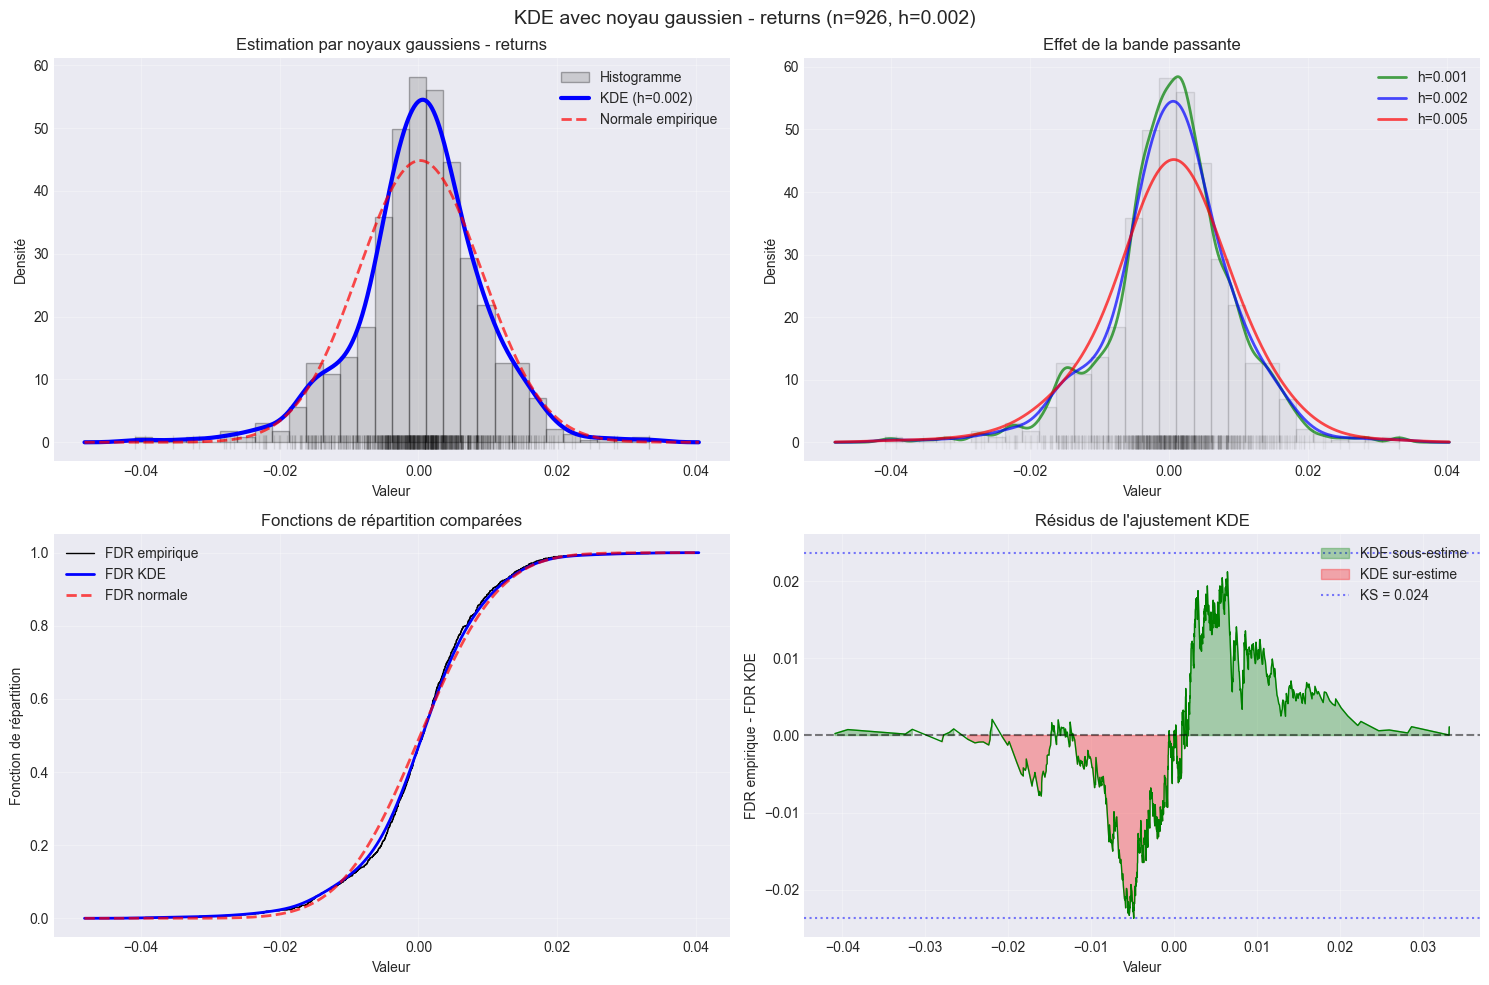


QUALITÉ DE L'AJUSTEMENT KDE:
----------------------------------------
Integrated Squared Error (ISE): 0.137155
Statistique Kolmogorov-Smirnov: 0.023666
Log-vraisemblance: 3103.17

COMPARAISON KDE vs DISTRIBUTION NORMALE:
----------------------------------------
Différence intégrée L1: 0.160009
Log-vraisemblance Normale: 3058.55
Différence de log-vraisemblance: 44.62
→ KDE a une meilleure vraisemblance que la normale

ESTIMATION DES QUANTILES PAR KDE:
----------------------------------------
Quantile   KDE          Empirique    Normale     
--------------------------------------------------
  1.0%     -0.025697    -0.024680    -0.020457
  5.0%     -0.015597    -0.015278    -0.014393
 25.0%     -0.004523    -0.004185    -0.005758
 50.0%      0.000615     0.000650     0.000244
 75.0%      0.005753     0.005273     0.006245
 95.0%      0.014701     0.014091     0.014880
 99.0%      0.021522     0.019978     0.020944


In [63]:
kde = kde_gaussien_complet(train.returns)

In [64]:
alpha = 0.99
sim = kde['kde_object'].resample(100000).flatten()
var_kde = np.quantile(sim, 1-alpha)
print(f'VaR KDE : {var_kde}')

VaR KDE : -0.02560633476573422


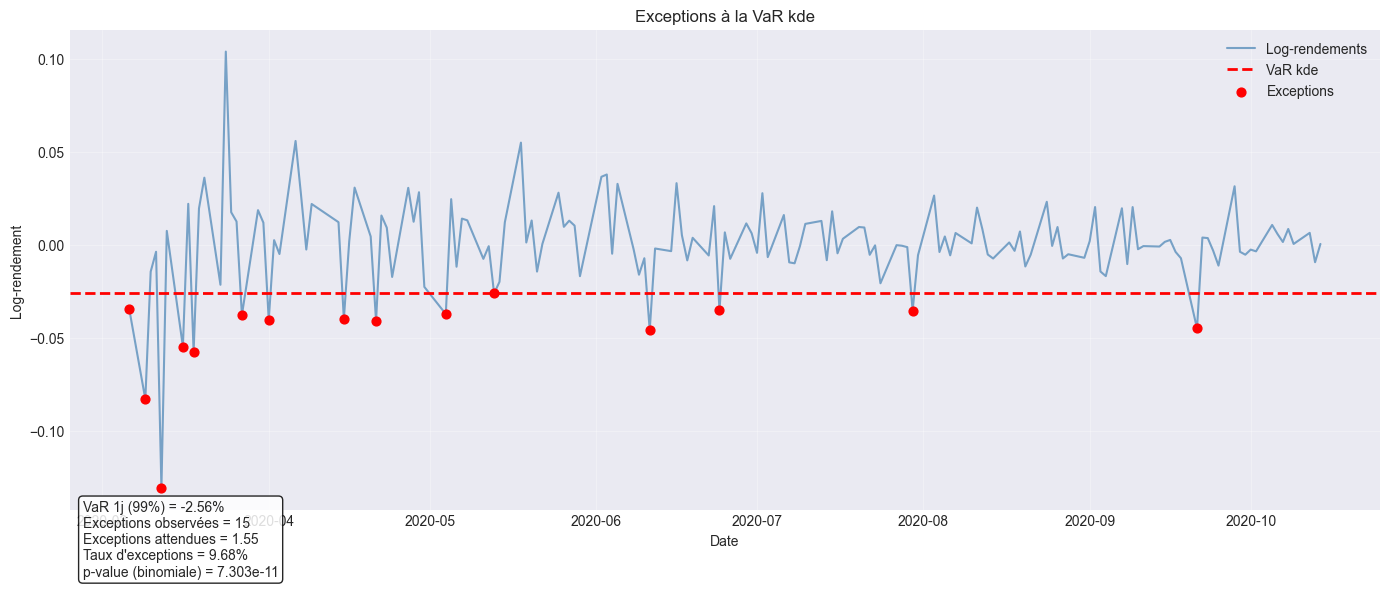

In [65]:
plot_exceptions(test.returns,alpha=0.99, var= var_kde,name='kde')

# 4.	Protocole de recalibrage
Vous êtes en poste, et votre responsable vous dresse ce cahier des charges :
a.	Il nous faut un modèle de VaR calibré initialement sur la période d’apprentissage ;
b.	Il faut ensuite que nous le backtestions de manière quotidienne ;
c.	Il faut que nous arrivions à évaluer le moment où nous avons besoin de le recalibrer, en considérant que
i.	Le recalibrage doit être justifié par un modèle inadapté aux données récentes ;
ii.	Un recalibrage trop fréquent n’est pas particulièrement souhaitable.
Proposer un protocole permettant de répondre à ces exigences, expliquer les choix retenus, et le mettre en place.


## Protocole de backtesting de la Value-at-Risk

Le backtesting a pour objectif d’évaluer la capacité prédictive du modèle de Value-at-Risk (VaR) hors échantillon. Le protocole mis en place repose sur une évaluation quotidienne des exceptions et sur des tests statistiques standards de couverture.

### 1. Calibration initiale

Le modèle de VaR est calibré une première fois sur une période d’apprentissage considérée comme représentative d’un régime de marché stable. Les paramètres estimés sont ensuite gelés et utilisés pour produire des prévisions de VaR hors échantillon.

### 2. Calcul quotidien de la VaR

À chaque date de la période de test, la VaR à un jour est calculée à partir des paramètres du modèle. Une exception est observée lorsque le rendement réalisé est inférieur à la VaR estimée.

$$
\text{Exception}_t =
\begin{cases}
1 & \text{si } r_t < \text{VaR}_t \\
0 & \text{sinon}
\end{cases}
$$

### 3. Suivi des exceptions

Les exceptions sont enregistrées quotidiennement et analysées sur une fenêtre glissante de backtesting (par exemple 250 observations). Le nombre d’exceptions observées est comparé au nombre d’exceptions théoriquement attendu compte tenu du niveau de confiance de la VaR.

### 4. Test statistique de couverture

La validité du modèle est évaluée à l’aide du test de couverture inconditionnelle de Kupiec. Sous l’hypothèse nulle d’un modèle correctement calibré, le nombre d’exceptions suit une loi binomiale de paramètre $1-\alpha$.

Le test permet de vérifier si le taux d’exceptions observé est compatible avec le niveau de risque attendu.

### 5. Critère d’acceptation du modèle

- Si la p-value du test est supérieure au seuil de 5 %, le modèle est considéré comme acceptable.
- Si la p-value est inférieure à 5 %, le modèle est jugé inadapté aux données observées.

### 6. Intégration dans un protocole de recalibrage

Afin d’éviter des recalibrages trop fréquents, un recalibrage du modèle n’est déclenché que si le rejet du test de couverture est observé de manière persistante sur plusieurs périodes consécutives. Cette approche permet de distinguer un changement structurel du régime de marché d’un choc ponctuel.


````python
for t in dates_test:
    compute VaR_t
    record exception_t
    
    if backtest_window_full:
        run binomial_test
        
        if rejection persists K days:
            recalibrate model

````

In [ ]:
def var_recalibration_protocol(
    returns,
    var_function,
    calibrate_function,
    alpha=0.99,
    train_window=500,
    backtest_window=250,
    persistence_days=10
):
    """
    Protocole de recalibrage de VaR
    
    Parameters
    ----------
    returns : pd.Series
        Série des log-rendements
    var_function : callable
        Fonction VaR(x, params, alpha)
    calibrate_function : callable
        Fonction d'estimation des paramètres
    """
    
    params = calibrate_function(returns.iloc[:train_window])
    recalibration_dates = []
    
    exceptions = []
    p_values = []
    var_series = []
    
    rejection_streak = 0
    
    for t in range(train_window, len(returns)):
        
        # VaR quotidienne
        var_t = var_function(returns.iloc[:t], params, alpha)
        var_series.append(var_t)
        
        r_t = returns.iloc[t]
        exception = int(r_t < var_t)
        exceptions.append(exception)
        
        # Backtesting sur fenêtre glissante
        if len(exceptions) >=  :
            
            recent_exceptions = exceptions[-backtest_window:]
            k = sum(recent_exceptions)
            n = backtest_window
            
            test = binomtest(k, n, 1 - alpha, alternative='greater')
            p_values.append(test.pvalue)
            
            # Détection de rejet
            if test.pvalue < 0.05:
                rejection_streak += 1
            else:
                rejection_streak = 0
            
            # Recalibrage
            if rejection_streak >= persistence_days:
                params = calibrate_function(
                    returns.iloc[t - train_window:t]
                )
                recalibration_dates.append(returns.index[t])
                rejection_streak = 0
        else:
            p_values.append(np.nan)
    
    return {
        'VaR': pd.Series(var_series, index=returns.index[train_window:]),
        'exceptions': pd.Series(exceptions, index=returns.index[train_window:]),
        'p_values': pd.Series(p_values, index=returns.index[train_window:]),
        'recalibration_dates': recalibration_dates
    }


In [78]:
from scipy.stats import norm
def calibrate_gaussian(x):
    return {
        'mu': x.mean(),
        'sigma': x.std()
    }



def var_gaussian(x, params, alpha):
    return params['mu'] + params['sigma'] * norm.ppf(1 - alpha)

results = var_recalibration_protocol(
    returns=returns,
    var_function=var_gaussian,
    calibrate_function=calibrate_gaussian,
    alpha=0.99
)


<Axes: title={'center': 'p-value du test binomial (Kupiec)'}, xlabel='Date'>

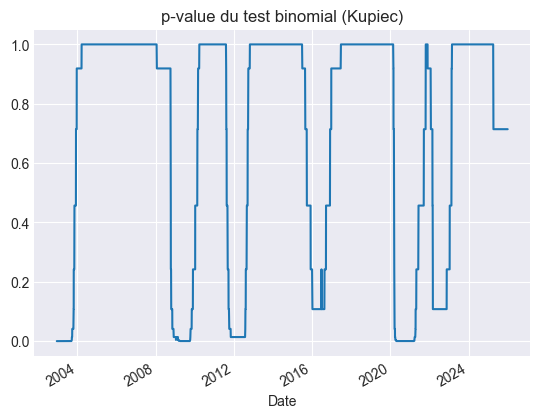

In [79]:
results['recalibration_dates']
results['exceptions'].sum()
results['p_values'].dropna().plot(title="p-value du test binomial (Kupiec)")


# 4. Protocole de recalibrage du modèle de VaR

L’objectif est de disposer d’un modèle de Value-at-Risk (VaR) initialement calibré sur une période d’apprentissage, capable d’être backtesté quotidiennement, tout en limitant les recalibrages inutiles. Le recalibrage doit être déclenché uniquement lorsque le modèle devient statistiquement inadapté aux données récentes.



### Principe général

Le modèle de VaR est calibré une première fois sur la période d’apprentissage. Il est ensuite backtesté quotidiennement sur une période de test à l’aide d’un test de couverture binomial (test de Kupiec). Le backtesting est réalisé sur une fenêtre glissante afin de tenir compte de l’évolution de la dynamique des rendements.

### Fenêtre de backtesting glissante

À chaque nouvelle observation :
- une fenêtre glissante de 250 observations est considérée ;
- la VaR est comparée aux rendements observés ;
- le nombre d’exceptions est comptabilisé ;
- un test binomial de couverture est effectué au seuil de 5 %.

Cette taille de fenêtre permet d’assurer une puissance suffisante du test, avec un nombre attendu d’exceptions compatible avec le niveau de risque de 99 %.

### Critère de recalibrage par persistance

Afin d’éviter des recalibrages trop fréquents dus à des rejets isolés, un critère de persistance est introduit. Les résultats des tests de couverture sont analysés sur une fenêtre mobile de 21 jours correspondant à un mois de marché.

Le modèle est recalibré si, et seulement si, au moins $\Delta$
 rejets du test binomial sont observés sur les 21 derniers jours. Ce critère permet d’identifier une inadéquation statistique persistante du modèle aux données récentes, tout en filtrant les chocs ponctuels. Sur une fenetre de 21 jours, on s'attend au seuil de 5% à 21 * 5% ~~ 1 rejet donc $Delta >=2$

```python
1. Construire la fenêtre glissante :
   - Fenêtre_t = { r_(t - N_train), ..., r_(t - 1) }

2. Calculer la VaR_t à partir du modèle courant

3. Tester l’exception :
   - Si r_t < VaR_t :
         exception_t = 1
     Sinon :
         exception_t = 0

4. Calculer le nombre total d’exceptions sur Fenêtre_t
   - k_t = somme des exceptions
   - n = N_train

5. Effectuer le test binomial de couverture :
   - H0 : taux d’exception = 1 - alpha
   - Calculer la p-value du test binomial

6. Enregistrer le résultat du test :
   - Si p-value < seuil_test :
         rejet_t = 1
     Sinon :
         rejet_t = 0
   - Ajouter rejet_t à Rejets_Test

7. Vérifier la condition de recalibrage :
   - Si le nombre de rejets sur les W derniers jours ≥ K :
         a. Recalibrer le modèle sur la dernière fenêtre de N_train observations
         b. Réinitialiser la liste Rejets_Test

```

In [100]:
from scipy.stats import binomtest

def backtesting_recalibrage(
    returns,
    compute_var,
    initial_var=None,
    alpha=0.99,
    N_train=250,
    W=21,
    K=None,
    seuil_test=0.05
):
    """
    Backtesting quotidien avec recalibrage adaptatif basé sur un test binomial

    Parameters
    ----------
    returns : pd.Series
        Série des log-rendements indexée par date
    compute_var : function
        Fonction de calcul de la VaR, signature : compute_var(x_train, alpha)
    alpha : float
        Niveau de confiance de la VaR
    N_train : int
        Taille de la fenêtre glissante
    W : int
        Fenêtre de surveillance des rejets
    K : int
        Nombre de rejets déclenchant le recalibrage, si None, K = int(seuil_test*W)+1
    seuil_test : float
        Seuil de rejet du test binomial

    Returns
    -------
    results : dict
        Dictionnaire contenant VaR, exceptions, p-values et dates de recalibrage
    """

    dates = returns.index
    T = len(returns)

    VaR_series = []
    exceptions = []
    p_values = []
    recalibration_dates = []

    rejets_recent = []
    if K is None:
        K = int(np.floor(seuil_test * W))+1
    if initial_var is None:
        initial_var = compute_var(returns.iloc[:N_train], alpha)
        

    for t in range(N_train, T):

        # 1. Fenêtre d'apprentissage glissante
        train_window = returns.iloc[t - N_train:t]
        r_t = returns.iloc[t]

        # 2. Calcul de la VaR
        VaR_t = initial_var

        # 3. Détection de l'exception
        exception = int(r_t < VaR_t)
        exceptions.append(exception)

        # 4. Test binomial sur la fenêtre courante
        k = np.sum(train_window < VaR_t)
        n = N_train

        test = binomtest(k, n, 1 - alpha, alternative='greater')
        p_val = test.pvalue
        p_values.append(p_val)

        # 5. Enregistrement du rejet
        rejet = int(p_val < seuil_test)
        rejets_recent.append(rejet)

        # 6. Surveillance des W derniers jours
        if len(rejets_recent) > W:
            rejets_recent.pop(0)

        # 7. Condition de recalibrage
        if sum(rejets_recent) >= K:
            recalibration_dates.append(dates[t])
            VaR_t = compute_var(train_window, alpha)
            rejets_recent = []  # reset après recalibrage
        VaR_series.append(VaR_t)  # Ajouter la nouvelle VaR calculée
    return {
        "VaR": np.array(VaR_series),
        "exceptions": np.array(exceptions),
        "p_values": np.array(p_values),
        "recalibration_dates": recalibration_dates
    }


In [111]:
len(results["VaR"][0] * (len(df_returns.index)-len(results["VaR"])) + results["VaR"])

831

In [112]:
len(results["VaR"])

831

In [ ]:
def plot_var_backtesting(
    returns,
    results,
    alpha=0.99,
    title="Backtesting VaR – Exceptions et recalibrage"
):
    """
    Visualisation des rendements, VaR, exceptions et recalibrages
    """

    dates = returns.index#[-len(results["VaR"]):]
    r_test = returns#.iloc[-len(results["VaR"]):]
    VaR =  [results["VaR"][0]] * (len(dates)-len(results["VaR"])) + list(results["VaR"])
    exceptions = results["exceptions"]
    recalib_dates = results["recalibration_dates"]

    plt.figure(figsize=(14, 6))

    # Rendements
    plt.plot(dates, r_test, label="Log-rendements", color="steelblue", alpha=0.6)

    # VaR
    plt.plot(dates, VaR, label=f"VaR {int(alpha*100)}%", color="red", linewidth=2)

    # Exceptions
    exc_idx = np.where(exceptions == 1)[0]
    plt.scatter(
        dates[exc_idx],
        r_test[exc_idx],
        color="black",
        marker="x",
        s=60,
        label="Exceptions"
    )

    # Recalibrage
    # for d in recalib_dates:
    #     plt.axvline(d, color="purple", linestyle="--", alpha=0.6)

    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Rendement / VaR")
    plt.legend()
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


In [102]:
def VaR_Gauss(x, alpha):
    mu = np.mean(x)
    sigma = np.std(x)
    return mu + sigma * norm.ppf(1 - alpha)

df_returns = pd.concat([train.returns, test.returns])
results = backtesting_recalibrage(
    returns=df_returns,
    compute_var=VaR_Gauss,
    initial_var=var_gauss,
    K=3,
    W=21,
    alpha=0.99
)


C:\Users\UltraBook 3.1\AppData\Local\Temp\ipykernel_24048\2286803707.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  r_test[exc_idx],


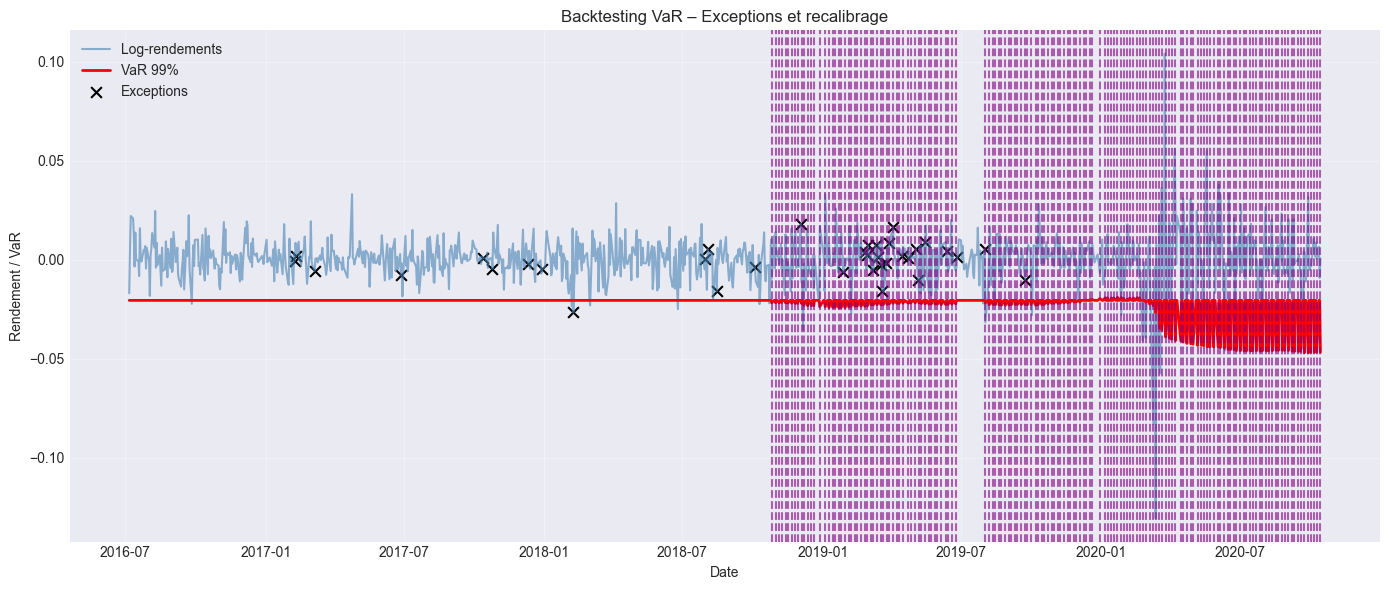

In [116]:
plot_var_backtesting(
    returns=df_returns,
    results=results,
    alpha=0.99,
    title="Backtesting VaR – Exceptions et recalibrage"
)